<a href="https://colab.research.google.com/github/abhishekshakya/BPSO-and-ANN-for-sofware-fault-predicition/blob/master/JOURNAL_Results_PSO_ANNv2_ALL_LOSS_FUNCS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
#https://ieeexplore.ieee.org/abstract/document/8011255
#from SVM https://www.youtube.com/watch?v=_PwhiWxHK8o

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# !pip install -U skorch

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from scipy.io import arff
from sklearn.model_selection import cross_val_score
# from skorch import NeuralNetClassifier
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [ ]:
pc1 = pd.read_csv('/content/drive/My Drive/dataset/PC1.csv')
kc1 = pd.read_csv('/content/drive/My Drive/dataset/KC1.csv')
kc3 = pd.read_csv('/content/drive/My Drive/dataset/KC3.csv')
jm1 = pd.read_csv('/content/drive/My Drive/dataset/JM1.csv')   

##Data cleaning

#####For kc2, here y feature is in object type

In [ ]:
#for kc2 here change output feature from object -> bool
# p = df_kc2['defects']
# map = {'yes':True, 'no':False}
# df_kc2['defects'] = p.map(map)
def output_red(df):
  p = df.iloc[:,-1]
  map = {'Y':True, 'N':False}
  df.iloc[:,-1] = p.map(map)
  return df

df_pc1 = output_red(pc1)
df_kc1 = output_red(kc1)
df_kc3 = output_red(kc3)
df_jm1 = output_red(jm1)

In [ ]:
df_kc3.head()

,LOC_BLANK,BRANCH_COUNT,CALL_PAIRS,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CONDITION_COUNT,CYCLOMATIC_COMPLEXITY,CYCLOMATIC_DENSITY,DECISION_COUNT,DECISION_DENSITY,DESIGN_COMPLEXITY,DESIGN_DENSITY,EDGE_COUNT,ESSENTIAL_COMPLEXITY,ESSENTIAL_DENSITY,LOC_EXECUTABLE,PARAMETER_COUNT,GLOBAL_DATA_COMPLEXITY,GLOBAL_DATA_DENSITY,HALSTEAD_CONTENT,HALSTEAD_DIFFICULTY,HALSTEAD_EFFORT,HALSTEAD_ERROR_EST,HALSTEAD_LENGTH,HALSTEAD_LEVEL,HALSTEAD_PROG_TIME,HALSTEAD_VOLUME,MAINTENANCE_SEVERITY,MODIFIED_CONDITION_COUNT,MULTIPLE_CONDITION_COUNT,NODE_COUNT,NORMALIZED_CYLOMATIC_COMPLEXITY,NUM_OPERANDS,NUM_OPERATORS,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,NUMBER_OF_LINES,PATHOLOGICAL_COMPLEXITY,PERCENT_COMMENTS,LOC_TOTAL,Defective
0,0,1,1,0,0,0,1,0.33,0,?,1,1.00,2,1,0.00,3,0,1,1.00,6.20,2.50,38.77,0.01,6,0.40,2.15,15.51,1.00,0,0,3,0.25,1,5,1,5,4,1,0.00,3,False
1,0,1,5,0,1,0,1,0.20,0,?,1,1.00,6,1,0.00,5,0,1,1.00,32.50,5.32,919.39,0.06,40,0.19,51.08,172.88,1.00,0,0,7,0.13,13,27,11,9,8,1,16.67,5,False
2,22,43,20,3,11,38,26,0.20,18,2.11,18,0.69,132,15,0.56,128,0,19,0.73,109.63,42.03,193686.35,1.54,666,0.02,10760.35,4607.96,0.58,10,19,108,0.16,255,411,91,30,166,1,9.86,131,False
3,2,11,10,0,1,12,7,0.20,6,2,6,0.86,38,1,0.00,35,0,5,0.71,55.65,17.14,16352.99,0.32,165,0.06,908.50,953.92,0.14,3,6,33,0.18,60,105,35,20,39,1,2.78,35,False
4,0,7,2,0,0,4,5,0.22,2,2,4,0.80,19,3,0.50,23,0,4,0.80,29.40,14.39,6090.84,0.14,89,0.07,338.38,423.18,0.60,1,2,16,0.21,31,58,14,13,24,1,0.00,23,False


In [ ]:
def normalize(x):
  x = x.astype(float)
  min = np.min(x)
  max = np.max(x)
  return (x - min)/(max-min)

####For jm1, we have '?' randomly distributed so we need to remove them also

In [ ]:
# d1,d2,d3,d4,d5 = df_jm1.iloc[:,16], df_jm1.iloc[:,17], df_jm1.iloc[:,18], df_jm1.iloc[:,19], df_jm1.iloc[:,20]

# for i in range(len(d1)):
#   if (str)(d1[i]) == '?' or (str)(d2[i]) == '?' or (str)(d3[i]) == '?' or (str)(d4[i]) == '?' or (str)(d5[i]) == '?':
#     df_jm1.drop(i,inplace=True)
#     i -= 1

def clean(df):
  for d in tqdm(range(len(df.iloc[0]))):
    i=0
    d1 = df.iloc[:,d]
    # print(type(d1))
    while i<len(d1):
      if (str)(d1.iloc[i]) == '?':
        # print(d1.iloc[i])
        df.drop(i,inplace=True)
      i += 1




In [ ]:
# print(x_real)
# print(y_real)
print(f"initial shapes {df_kc3.shape} {df_kc1.shape} {df_jm1.shape} {df_pc1.shape}")
clean(df_kc3)
clean(df_kc1)
clean(df_jm1)
clean(df_pc1)
print(f"after shapes {df_kc3.shape} {df_kc1.shape} {df_jm1.shape} {df_pc1.shape}")
# df_kc3.head()
# df_pc1.drop()

initial shapes (458, 41) (2107, 22) (10878, 22) (1107, 41)



after shapes (200, 41) (2107, 22) (10878, 22) (759, 41)


In [ ]:
print(df_kc1.columns)
print(df_kc3.columns)
print(df_pc1.columns)
print(df_jm1.columns)

Index(['LOC_BLANK', 'BRANCH_COUNT', 'LOC_CODE_AND_COMMENT', 'LOC_COMMENTS',
       'CYCLOMATIC_COMPLEXITY', 'DESIGN_COMPLEXITY', 'ESSENTIAL_COMPLEXITY',
       'LOC_EXECUTABLE', 'HALSTEAD_CONTENT', 'HALSTEAD_DIFFICULTY',
       'HALSTEAD_EFFORT', 'HALSTEAD_ERROR_EST', 'HALSTEAD_LENGTH',
       'HALSTEAD_LEVEL', 'HALSTEAD_PROG_TIME', 'HALSTEAD_VOLUME',
       'NUM_OPERANDS', 'NUM_OPERATORS', 'NUM_UNIQUE_OPERANDS',
       'NUM_UNIQUE_OPERATORS', 'LOC_TOTAL', 'Defective'],
      dtype='object')
Index(['LOC_BLANK', 'BRANCH_COUNT', 'CALL_PAIRS', 'LOC_CODE_AND_COMMENT',
       'LOC_COMMENTS', 'CONDITION_COUNT', 'CYCLOMATIC_COMPLEXITY',
       'CYCLOMATIC_DENSITY', 'DECISION_COUNT', 'DECISION_DENSITY',
       'DESIGN_COMPLEXITY', 'DESIGN_DENSITY', 'EDGE_COUNT',
       'ESSENTIAL_COMPLEXITY', 'ESSENTIAL_DENSITY', 'LOC_EXECUTABLE',
       'PARAMETER_COUNT', 'GLOBAL_DATA_COMPLEXITY', 'GLOBAL_DATA_DENSITY',
       'HALSTEAD_CONTENT', 'HALSTEAD_DIFFICULTY', 'HALSTEAD_EFFORT',
       'HALSTEAD_ERRO

In [ ]:
req_cols = df_kc1.columns
df_jm1.rename(columns = {'label':'Defective'}, inplace = True) 
df_jm1 = df_jm1[req_cols]
df_kc1 = df_kc1[req_cols]
df_kc3 = df_kc3[req_cols]
df_pc1 = df_pc1[req_cols]

In [ ]:
print(df_kc1.columns)
print(df_kc3.columns)
print(df_pc1.columns)
print(df_jm1.columns)

Index(['LOC_BLANK', 'BRANCH_COUNT', 'LOC_CODE_AND_COMMENT', 'LOC_COMMENTS',
       'CYCLOMATIC_COMPLEXITY', 'DESIGN_COMPLEXITY', 'ESSENTIAL_COMPLEXITY',
       'LOC_EXECUTABLE', 'HALSTEAD_CONTENT', 'HALSTEAD_DIFFICULTY',
       'HALSTEAD_EFFORT', 'HALSTEAD_ERROR_EST', 'HALSTEAD_LENGTH',
       'HALSTEAD_LEVEL', 'HALSTEAD_PROG_TIME', 'HALSTEAD_VOLUME',
       'NUM_OPERANDS', 'NUM_OPERATORS', 'NUM_UNIQUE_OPERANDS',
       'NUM_UNIQUE_OPERATORS', 'LOC_TOTAL', 'Defective'],
      dtype='object')
Index(['LOC_BLANK', 'BRANCH_COUNT', 'LOC_CODE_AND_COMMENT', 'LOC_COMMENTS',
       'CYCLOMATIC_COMPLEXITY', 'DESIGN_COMPLEXITY', 'ESSENTIAL_COMPLEXITY',
       'LOC_EXECUTABLE', 'HALSTEAD_CONTENT', 'HALSTEAD_DIFFICULTY',
       'HALSTEAD_EFFORT', 'HALSTEAD_ERROR_EST', 'HALSTEAD_LENGTH',
       'HALSTEAD_LEVEL', 'HALSTEAD_PROG_TIME', 'HALSTEAD_VOLUME',
       'NUM_OPERANDS', 'NUM_OPERATORS', 'NUM_UNIQUE_OPERANDS',
       'NUM_UNIQUE_OPERATORS', 'LOC_TOTAL', 'Defective'],
      dtype='object')
Index(

In [ ]:
df_kc3.describe()

,LOC_BLANK,BRANCH_COUNT,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CYCLOMATIC_COMPLEXITY,DESIGN_COMPLEXITY,ESSENTIAL_COMPLEXITY,LOC_EXECUTABLE,HALSTEAD_CONTENT,HALSTEAD_DIFFICULTY,HALSTEAD_EFFORT,HALSTEAD_ERROR_EST,HALSTEAD_LENGTH,HALSTEAD_LEVEL,HALSTEAD_PROG_TIME,HALSTEAD_VOLUME,NUM_OPERANDS,NUM_OPERATORS,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,LOC_TOTAL
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,4.680000,10.685000,0.225000,2.395000,6.265000,5.370000,2.635000,31.77000,50.647050,17.276850,30130.982150,0.366150,182.93000,0.075450,1673.943050,1098.246250,67.545000,115.385000,28.785000,15.960000,31.995000
std,5.746539,9.975134,0.835383,4.732967,5.568647,4.767256,2.979288,33.46861,37.613677,9.509496,63482.585459,0.484666,202.61158,0.039657,3526.809982,1455.086717,77.326353,125.571645,25.291244,4.872072,33.857891
min,0.000000,3.000000,0.000000,0.000000,2.000000,1.000000,1.000000,4.00000,13.380000,3.500000,238.400000,0.020000,19.00000,0.020000,13.240000,68.110000,5.000000,13.000000,4.000000,7.000000,4.000000
25%,0.750000,3.000000,0.000000,0.000000,2.000000,2.000000,1.000000,11.00000,25.407500,10.500000,3093.115000,0.090000,59.00000,0.050000,171.840000,279.630000,21.000000,40.000000,12.750000,12.750000,11.000000
50%,2.500000,7.000000,0.000000,0.000000,4.000000,4.000000,1.000000,20.00000,37.415000,14.785000,8230.420000,0.180000,104.00000,0.070000,457.245000,533.165000,37.000000,68.000000,19.000000,15.000000,20.000000
75%,7.000000,12.250000,0.000000,3.000000,7.000000,6.000000,3.000000,41.00000,64.722500,20.625000,29584.672500,0.452500,227.00000,0.100000,1643.595000,1362.265000,83.250000,144.500000,38.250000,19.000000,41.500000
max,28.000000,59.000000,9.000000,38.000000,36.000000,34.000000,20.000000,241.00000,238.080000,54.540000,582830.350000,3.560000,1413.00000,0.290000,32379.460000,10685.450000,556.000000,857.000000,159.000000,31.000000,242.000000


In [ ]:
val = df_kc3.iloc[:,-1]
print(sum(val==False),sum(val==True),df_kc1.shape)
print(sum(val==False)/len(val))

def KL(P,Q):
  epsilon = 0.00001
  P = P+epsilon
  Q = Q+epsilon

  divergence = np.sum(P*np.log(P/Q))
  return divergence

164 36 (2107, 22)
0.82


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
class ANN(nn.Module):
  def __init__(self,features, nodes1, nodes2):
    super().__init__()
    self.l1 = nn.Linear(features, nodes1)
    self.l2 = nn.Linear(nodes1, nodes2)
    self.l3 = nn.Linear(nodes2 ,1)

  def forward(self,x):
    x = F.relu(self.l1(x))
    x = F.relu(self.l2(x))
    x = (self.l3(x))
    return torch.sigmoid((x))

class network:
  def __init__(self, nodes1, nodes2, dim, r):
    """nodes = number of neural nodes in first layer
       dim = number of features
       r = learning rate
      """
    self.ANN = ANN(dim, nodes1, nodes2)
    self.optim = optim.Adam(self.ANN.parameters(), lr=r)
    self.criterion = nn.BCELoss()

  def fit(self, x, y, iterations):
    ANN = self.ANN
    optimizer = self.optim
    criterion = self.criterion
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).float()
    # y = y.reshape(y.shape[0],1)
    self.losses = []
    for i in (range(iterations)):

      optimizer.zero_grad()
    
      y_pred = ANN(x)
      y_pred = y_pred.squeeze()
      loss = criterion(y_pred, y)

      loss.backward()
      optimizer.step()
      self.losses.append(loss.item())
      # if i%((int)(iterations*0.05)) == 0:
      #   print(f"epoch {i}/{iterations}| loss=>{loss.item()}")
  
  def predict(self, x):
    ANN = self.ANN
    x = torch.from_numpy(x).float()
    y_ = ANN(x)
    y_ = y_.reshape(y_.shape[0])
    y_res = []
    for i in range(len(y_)):
      if y_[i] >= 0.5 :
        y_res.append(1)
      else:
        y_res.append(0)
    return y_res,y_.detach().cpu().numpy()

In [ ]:
class PSO:
  def __init__(self,particles, dimensions, lb, ub, itrations, c1, c2, w, xr, yr, node1, node2, lr, epochs, loss_function):
    self.node1 = node1
    self.node2 = node2
    self.lr = lr
    self.epochs = epochs
    self.loss_function = loss_function

    self.xr = xr
    self.yr = yr
    self.lb = lb
    self.ub = ub
    self.p = particles
    self.d = dimensions
    self.n = itrations
    self.c1 = c1
    self.c2 = c2
    self.w = w
    self.fitness_value = np.zeros(particles)+float('inf')#p
    self.X = np.random.randint(2,size=(particles,dimensions))#pxd
    self.V = np.random.randint(2,size=(particles,dimensions))#pxd
    self.pbest = self.X#pxd
    self.gbest = np.zeros(dimensions)#d
    self.maxg = float('inf')
    self.run()

  def sigmoid(self,x):
    return 1/(1+np.exp(-x))
  
  def count(self,x):
    c = np.sum(x)
    return c

  def fitness(self,x):
    x_train = []
    y_train = self.yr

    for i in range(self.d):
      if x[i] == 1:
        x_train.append(self.xr[:,i])

    x_train = np.array(x_train).reshape((self.xr.shape[0],-1))

    if x_train.shape[1] == 0:#no feature selected then return 0 acc
      return float('inf')
    #Stratified K Fold cross Validation-----------------------------------------------
    kfold =StratifiedKFold(n_splits=10)
    cc = 0
    accs = []
    for train_index, test_index in kfold.split(x_train, y_train):
      cc += 1
      x_train_fold = x_train[train_index] 
      y_train_fold = y_train[train_index] 
      x_test_fold = x_train[test_index] 
      y_test_fold = y_train[test_index]
      # neural Networks --------------overfitting----------------
      # net = network(self.node1,self.node2, x_train_fold.shape[1], self.lr)
      # net.fit(x_train_fold, y_train_fold, self.epochs)
      # ans,_ = net.predict(x_test_fold)
      #----------------------------------------------------------
      #---------KNN----------------------------------------------
      clf = KNeighborsClassifier(2)
      clf.fit(x_train_fold, y_train_fold)
      ans = clf.predict_proba(x_test_fold)
      #-------------------------------------------------------------
      # print(ans)
      # acc = ((ans==y_test_fold).sum()*1.0)/len(ans)#log loss
      loss = 0
      if self.loss_function==1:#BCE
        loss = metrics.log_loss(y_test_fold,  ans[:,1])#acc
      elif self.loss_function==2:#HingeLoss
        loss = metrics.hinge_loss(y_test_fold,  ans[:,1]);
      else:
        loss = KL(y_test_fold,  ans[:,1])

      accs.append(loss)

    # print(accs)
    return np.array(accs).mean()

  def run(self):
    for itr in tqdm(range(self.n)):
      if itr%5 == 0:
        print(f"iterations {itr} | min loss achieved {self.maxg} using {self.count(self.gbest)} features")
      for i in range(self.p):
        fit = self.fitness(self.X[i])
        if fit < self.fitness_value[i]:
          self.pbest[i] = np.copy(self.X[i])
          self.fitness_value[i] = fit

        if fit < self.maxg:
          self.gbest = np.copy(self.X[i])
          self.maxg = fit

        if fit == self.maxg and (self.count(self.X[i]) < self.count(self.gbest)):
          self.gbest = np.copy(self.X[i])

      for p in range(self.p):
        for q in range(self.d):
          r1 = np.random.randn()
          r2 = np.random.randn()
          self.V[p][q] = self.w * self.V[p][q] + self.c1*r1*(self.pbest[p][q] - self.X[p][q]) + self.c2*r2*(self.gbest[q] - self.X[p][q])

          if self.V[p][q] > self.ub:
            self.V[p][q] = self.ub
          if self.V[p][q] < self.lb:
            self.V[p][q] = self.lb

          if self.sigmoid(self.V[p][q]) > np.random.uniform(0,1):
            self.X[p][q] = 1
          else:
            self.X[p][q] = 0

      if fit == 0.0: #stop when loss is 0
          return
        


In [ ]:
def get(p, lb, ub, it, c1, c2, w, node1, node2, lr, epochs, df,loss_function):
  x = df.iloc[:,:-1].apply(func= normalize, axis=0).values
  y = df.iloc[:,-1].values.astype(int)

  pp = PSO(p,x.shape[1],lb,ub,it,c1,c2,w, x, y,node1,node2,lr,epochs,loss_function)

  return pp

def ROC_curve(df,node1, node2, lr, epochs, name, pp):
  x = df.iloc[:,:-1].apply(func= normalize, axis=0).values
  y = df.iloc[:,-1].values.astype(int)

  # #------------------------------------------------ROC curve---------------------------------------
  print(f"for {name}")
  print(f"selected metrics :")
  cols = []
  for i in range(len(pp.gbest)):
    if pp.gbest[i] == 1:
      cols.append(df.columns[i])
  
  print(f"number of features selected {len(cols)}")
  print(cols)
  res = df[cols]
  
  x_ruc = res.apply(func= normalize, axis = 0).values
  # print(x_ruc)

  kfold =StratifiedKFold(n_splits=10, shuffle=True)
  cc = 0
  aucs = []
  for train_index, test_index in kfold.split(x_ruc, y):
      cc += 1
      x_train_fold = x_ruc[train_index] 
      y_train_fold = y[train_index] 
      x_test_fold = x_ruc[test_index] 
      y_test_fold = y[test_index]

      net = network(node1,node2, x_train_fold.shape[1], lr)
      net.fit(x_train_fold, y_train_fold, epochs)
      prediction2, y2_prob = net.predict(x_test_fold) 
      # print(f"accuracy->{100*(((prediction2==y).sum()*1.0)/len(y))}")
      # print(y2_prob)
      # print(x_train_fold.shape, y_train_fold.shape,y2_prob.shape)

      # clf = SVC(probability=True)
      # clf.fit(x_train_fold, y_train_fold)
      # y2_prob = clf.predict_proba(x_test_fold)

      fpr, tpr, _= metrics.roc_curve(y_test_fold,y2_prob)
      auc = metrics.roc_auc_score(y_test_fold,y2_prob)
      fig,a = plt.subplots(1,2,figsize=(12,4))

      a[0].set_title("ROC")
      a[0].plot(fpr,tpr,label='auc: '+str(auc))
      a[0].legend(loc=4)
      a[1].set_title("Erorr Loss")
      a[1].plot(net.losses)
      plt.show()

      aucs.append(auc)
      #-------------------------------------------------------------
      # print(ans)
      # acc = ((ans==y_test_fold).sum()*1.0)/len(ans)
      # loss = metrics.log_loss(y_test_fold,  ans[:,1])
      # accs.append(loss)
  print(f"max AUC score of 10 k-Fold {max(aucs)}")


In [ ]:
p = 60 #number of particles
lb = -1 #min value for velocity 
ub = 1 #max value for velocity 
it = 100 #number of itrations
c1 = 2 # coefficient 1
c2 = 2 # coefficient 3
w = 0.4 #inertia

node1 = 4 #total number of nodes in layer1
node2 = 2 #total number of nodes in layer2
lr = 0.0016 #learning rate
epochs = 50 #epochs in ANN


In [ ]:
pso = get(p,lb,ub,it,c1,c2,w,node1,node2,lr,epochs,df_pc1,loss_function=1)

iterations 0 | min loss achieved inf using 0.0 features
iterations 5 | min loss achieved 2.080839200031124 using 7 features
iterations 10 | min loss achieved 2.080839200031124 using 7 features
iterations 15 | min loss achieved 2.080839200031124 using 7 features
iterations 20 | min loss achieved 2.080839200031124 using 7 features
iterations 25 | min loss achieved 2.080839200031124 using 7 features
iterations 30 | min loss achieved 2.080839200031124 using 7 features
iterations 35 | min loss achieved 2.080839200031124 using 7 features
iterations 40 | min loss achieved 2.080839200031124 using 7 features
iterations 45 | min loss achieved 2.080839200031124 using 7 features
iterations 50 | min loss achieved 2.080839200031124 using 7 features
iterations 55 | min loss achieved 2.080839200031124 using 7 features
iterations 60 | min loss achieved 2.080839200031124 using 7 features
iterations 65 | min loss achieved 2.008480212090034 using 7 features
iterations 70 | min loss achieved 2.008480212090

for pc1_BCE
selected metrics :
number of features selected 7
['LOC_CODE_AND_COMMENT', 'DESIGN_COMPLEXITY', 'LOC_EXECUTABLE', 'HALSTEAD_CONTENT', 'HALSTEAD_ERROR_EST', 'NUM_OPERATORS', 'NUM_UNIQUE_OPERANDS']


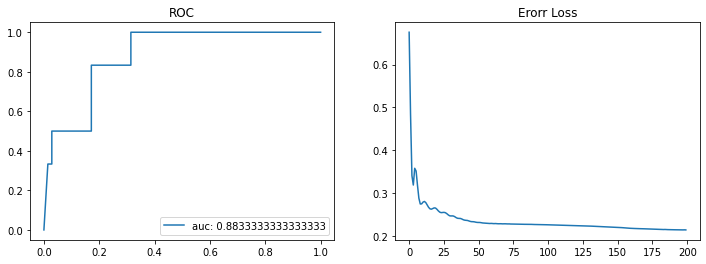

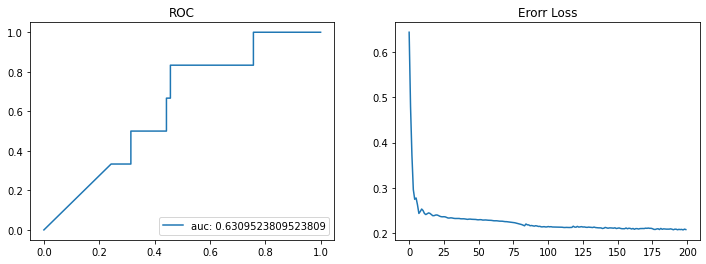

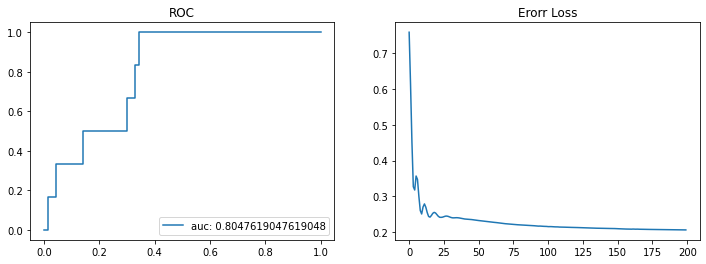

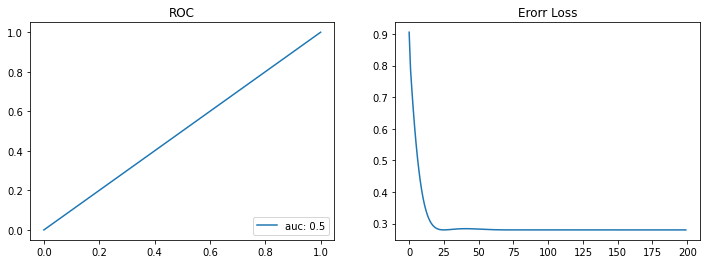

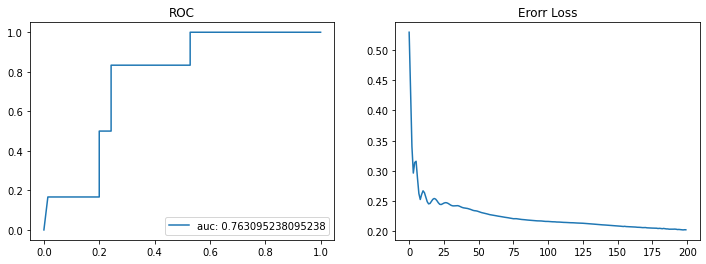

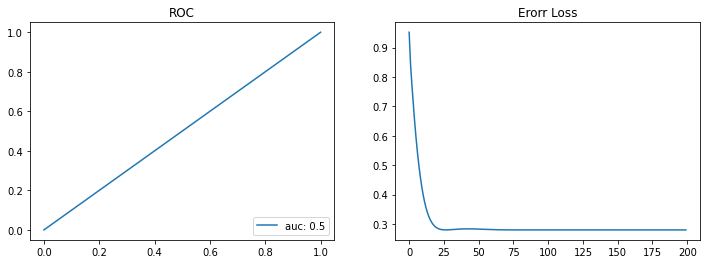

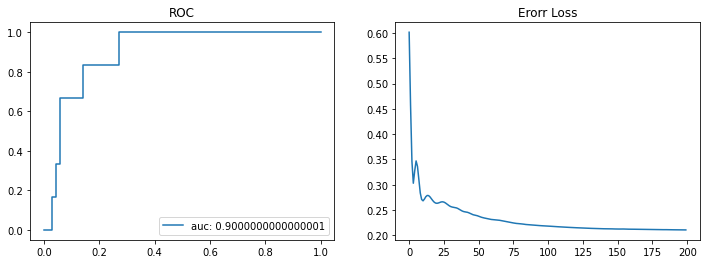

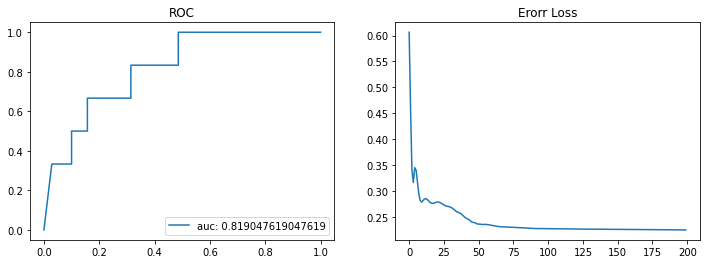

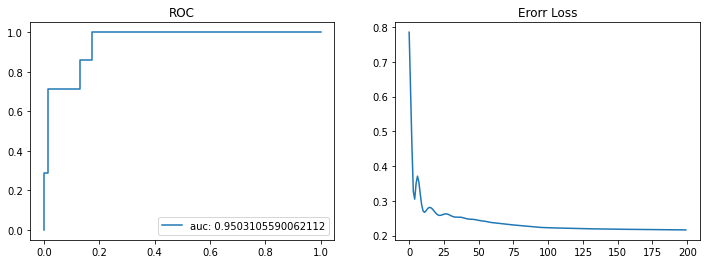

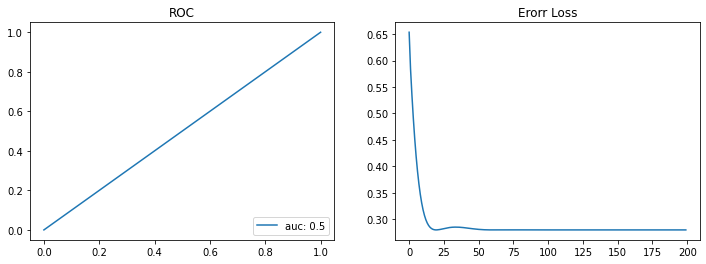

max AUC score of 10 k-Fold 0.9503105590062112


In [ ]:
ROC_curve(df_pc1, 8, 4, 0.15, 200,"pc1_BCE",pso)

In [ ]:
pso__hinge = get(p,lb,ub,it,c1,c2,w,node1,node2,lr,epochs,df_pc1,loss_function=2)

iterations 0 | min loss achieved inf using 0.0 features
iterations 5 | min loss achieved 1.0500263157894734 using 11 features
iterations 10 | min loss achieved 1.0460877192982456 using 11 features
iterations 15 | min loss achieved 1.0460877192982456 using 11 features
iterations 20 | min loss achieved 1.0454210526315788 using 12 features
iterations 25 | min loss achieved 1.0454210526315788 using 12 features
iterations 30 | min loss achieved 1.0454210526315788 using 12 features
iterations 35 | min loss achieved 1.0454210526315788 using 12 features
iterations 40 | min loss achieved 1.0454210526315788 using 12 features
iterations 45 | min loss achieved 1.0454210526315788 using 12 features
iterations 50 | min loss achieved 1.0454210526315788 using 12 features
iterations 55 | min loss achieved 1.0454210526315788 using 12 features
iterations 60 | min loss achieved 1.0454210526315788 using 12 features
iterations 65 | min loss achieved 1.0428070175438597 using 11 features
iterations 70 | min lo

for pc1_Hinge
selected metrics :
number of features selected 11
['LOC_BLANK', 'BRANCH_COUNT', 'LOC_CODE_AND_COMMENT', 'DESIGN_COMPLEXITY', 'LOC_EXECUTABLE', 'HALSTEAD_CONTENT', 'HALSTEAD_DIFFICULTY', 'HALSTEAD_LENGTH', 'NUM_OPERANDS', 'NUM_OPERATORS', 'LOC_TOTAL']


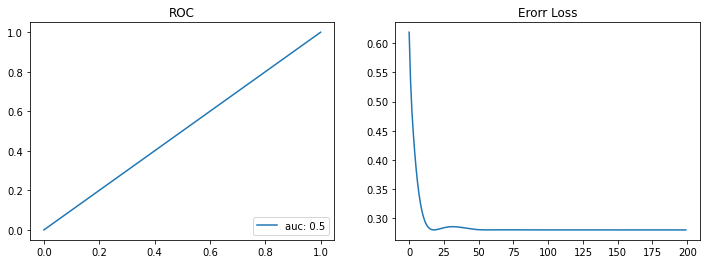

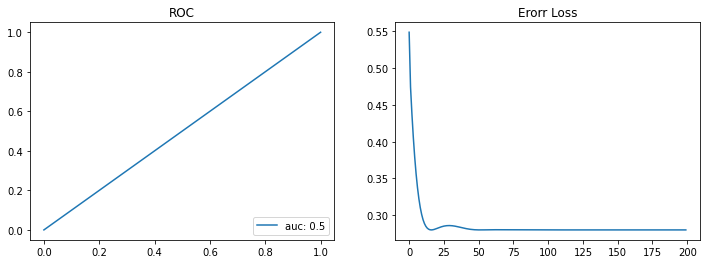

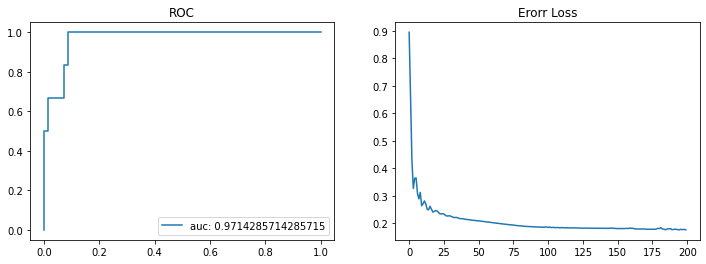

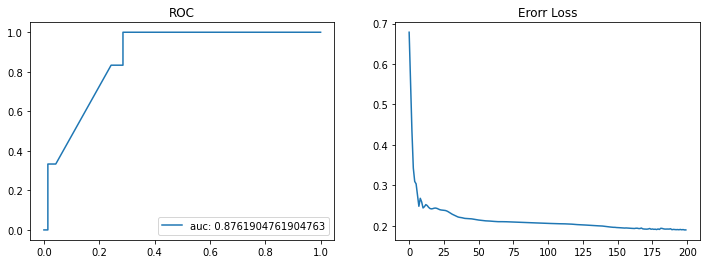

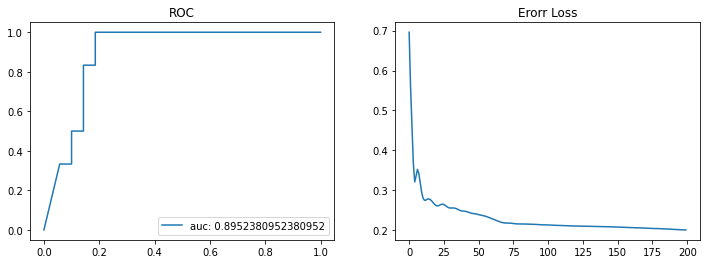

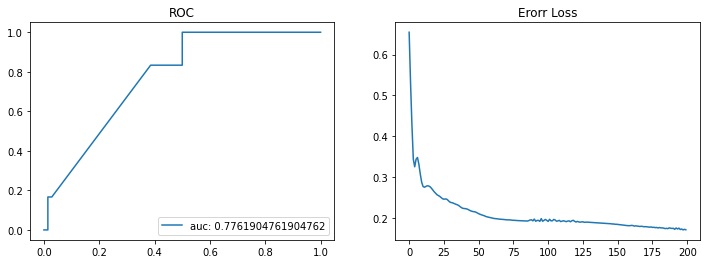

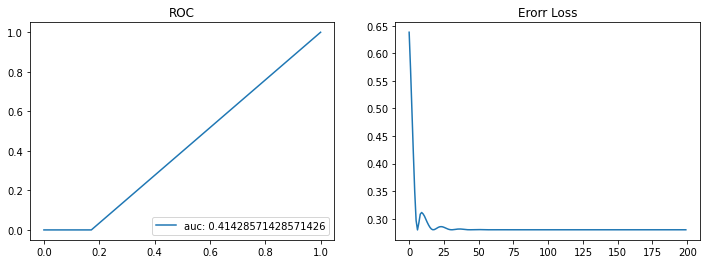

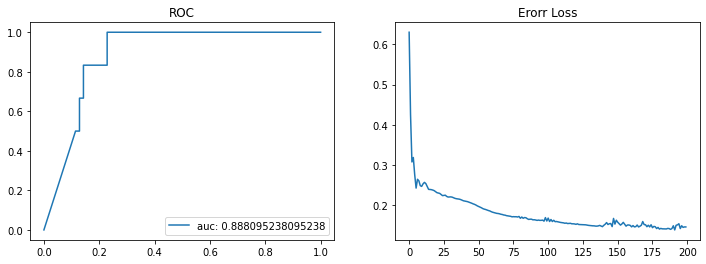

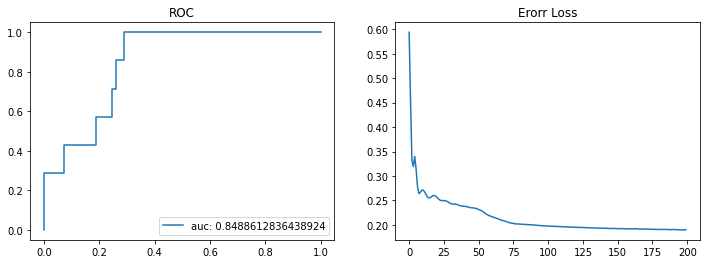

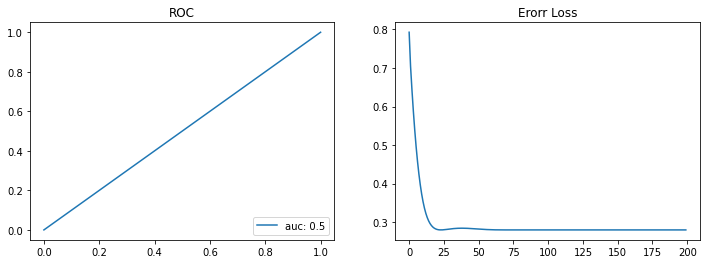

max AUC score of 10 k-Fold 0.9714285714285715


In [ ]:
ROC_curve(df_pc1, 8, 4, 0.15, 200,"pc1_Hinge",pso__hinge)

In [ ]:
pso__kl = get(p,lb,ub,it,c1,c2,w,node1,node2,lr,epochs,df_pc1,loss_function=3)

iterations 0 | min loss achieved inf using 0.0 features
iterations 5 | min loss achieved 51.76500307077358 using 6 features
iterations 10 | min loss achieved 49.53190835773053 using 7 features
iterations 15 | min loss achieved 48.5192558397275 using 7 features
iterations 20 | min loss achieved 48.5192558397275 using 7 features
iterations 25 | min loss achieved 48.5192558397275 using 7 features
iterations 30 | min loss achieved 48.5192558397275 using 7 features
iterations 35 | min loss achieved 47.43718598723429 using 7 features
iterations 40 | min loss achieved 47.367895988171405 using 7 features
iterations 45 | min loss achieved 46.21631974064964 using 7 features
iterations 50 | min loss achieved 46.21631974064964 using 7 features
iterations 55 | min loss achieved 46.21631974064964 using 7 features
iterations 60 | min loss achieved 46.21631974064964 using 7 features
iterations 65 | min loss achieved 46.21631974064964 using 7 features
iterations 70 | min loss achieved 46.21631974064964

for pc1_KL
selected metrics :
number of features selected 7
['LOC_CODE_AND_COMMENT', 'LOC_COMMENTS', 'DESIGN_COMPLEXITY', 'LOC_EXECUTABLE', 'HALSTEAD_EFFORT', 'HALSTEAD_LENGTH', 'NUM_UNIQUE_OPERATORS']


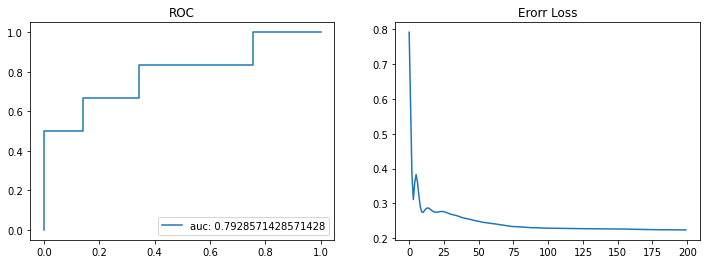

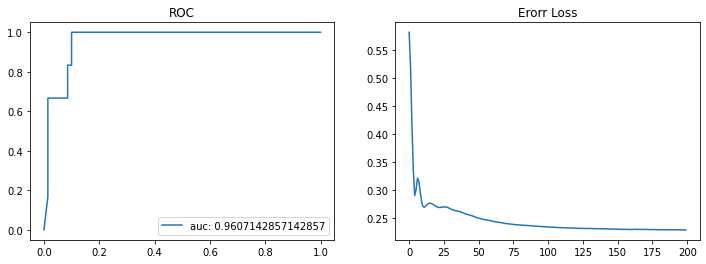

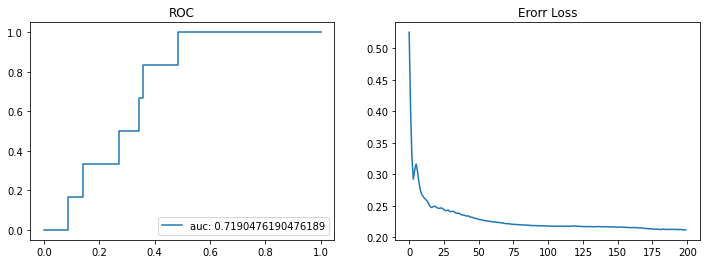

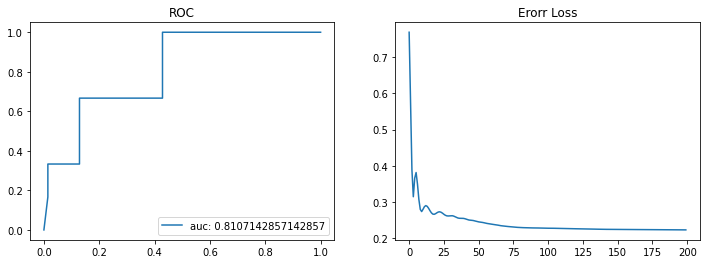

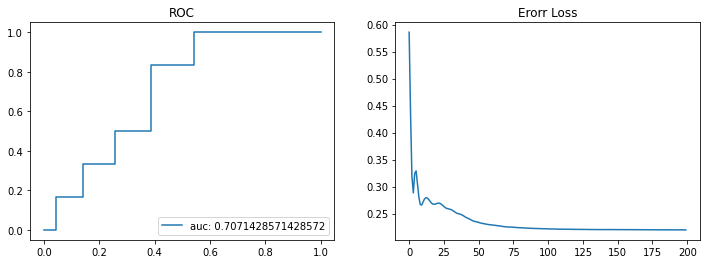

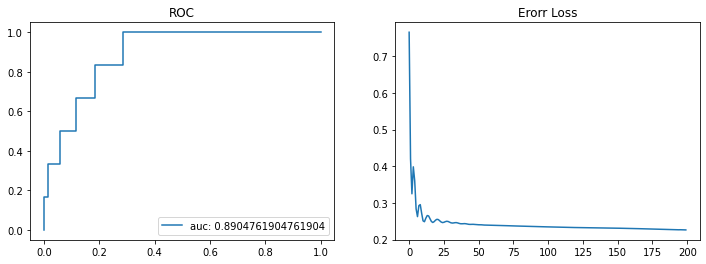

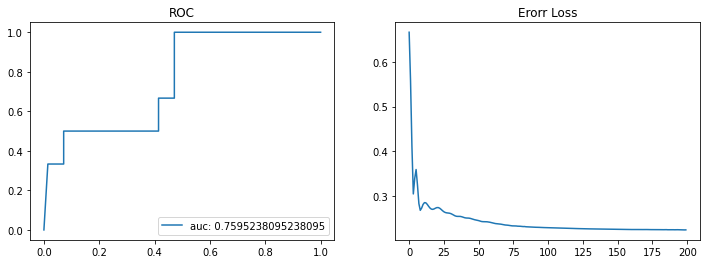

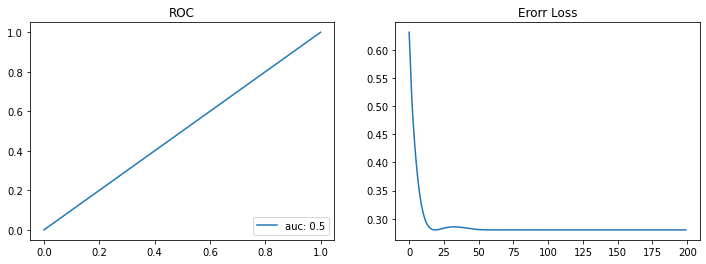

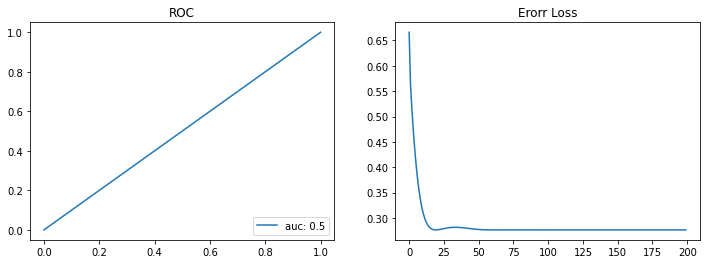

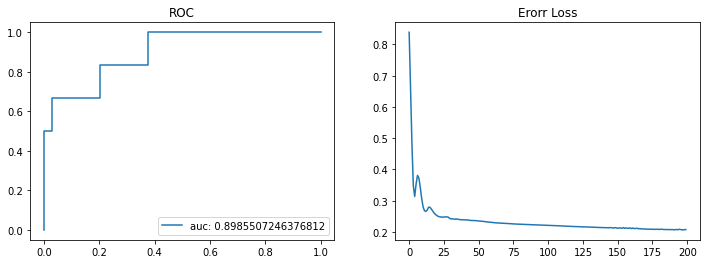

max AUC score of 10 k-Fold 0.9607142857142857


In [ ]:
ROC_curve(df_pc1, 8, 4, 0.15, 200,"pc1_KL",pso__kl)

In [ ]:
pso2 = get(p,lb,ub,it,c1,c2,w,node1,node2,lr,epochs,df_kc1,loss_function=1)

iterations 0 | min loss achieved inf using 0.0 features
iterations 5 | min loss achieved 4.062320810448825 using 9 features
iterations 10 | min loss achieved 3.988034643858355 using 8 features
iterations 15 | min loss achieved 3.594724508702181 using 7 features
iterations 20 | min loss achieved 3.594724508702181 using 7 features
iterations 25 | min loss achieved 3.594724508702181 using 7 features
iterations 30 | min loss achieved 3.594724508702181 using 7 features
iterations 35 | min loss achieved 3.594724508702181 using 7 features
iterations 40 | min loss achieved 3.594724508702181 using 7 features
iterations 45 | min loss achieved 3.594724508702181 using 7 features
iterations 50 | min loss achieved 3.594724508702181 using 7 features
iterations 55 | min loss achieved 3.594724508702181 using 7 features
iterations 60 | min loss achieved 3.594724508702181 using 7 features
iterations 65 | min loss achieved 3.594724508702181 using 7 features
iterations 70 | min loss achieved 3.594724508702

for kc1_BCE
selected metrics :
number of features selected 7
['LOC_CODE_AND_COMMENT', 'LOC_COMMENTS', 'ESSENTIAL_COMPLEXITY', 'LOC_EXECUTABLE', 'HALSTEAD_DIFFICULTY', 'NUM_UNIQUE_OPERANDS', 'LOC_TOTAL']


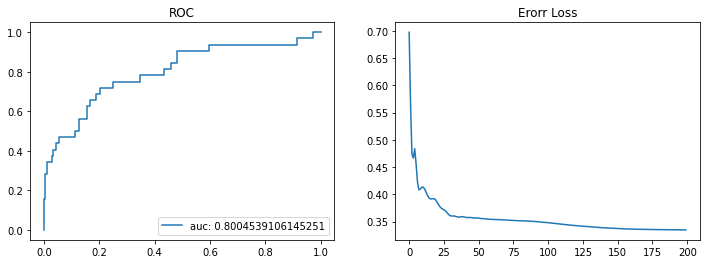

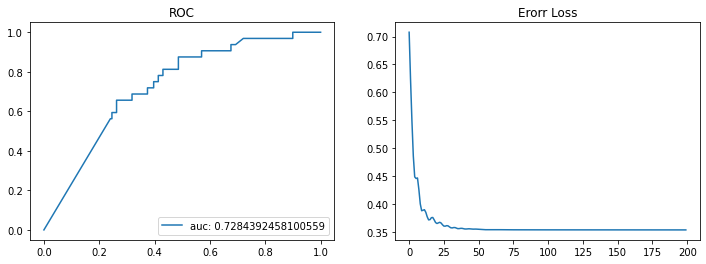

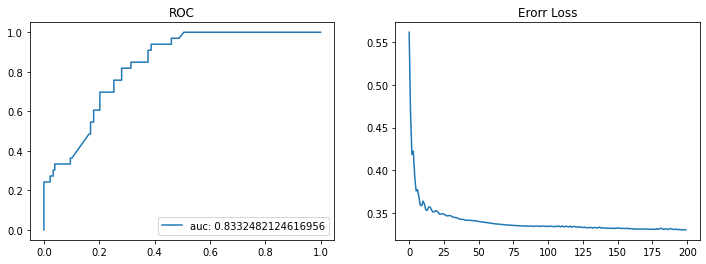

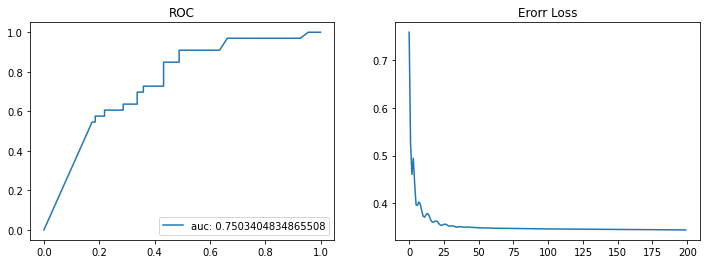

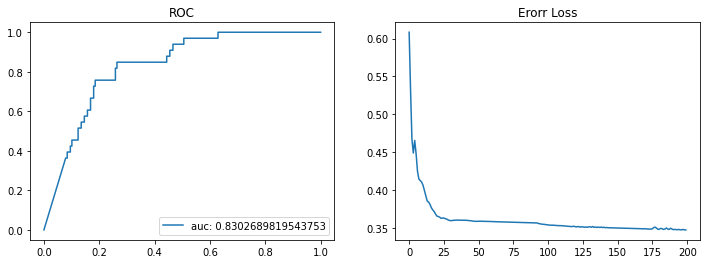

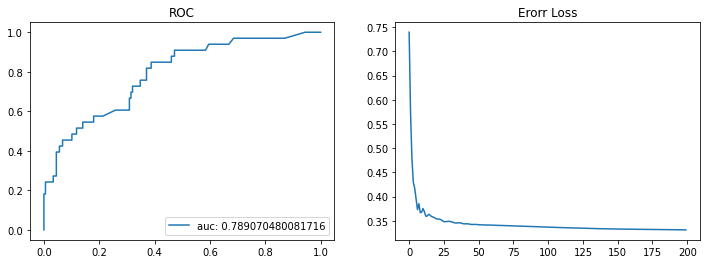

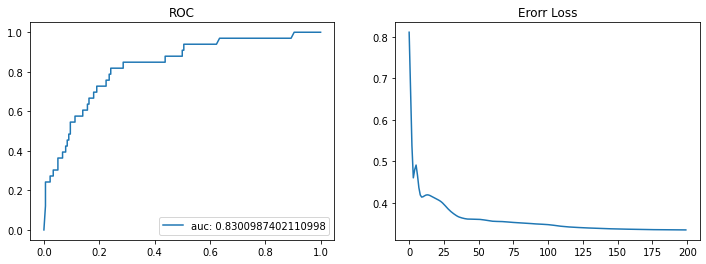

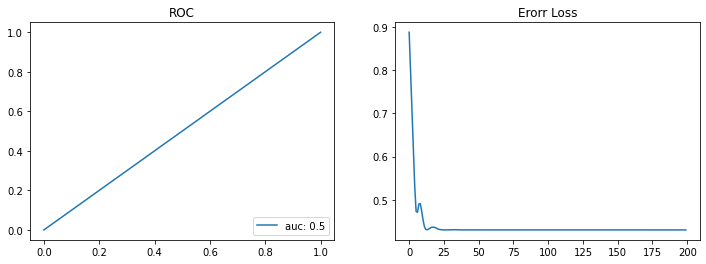

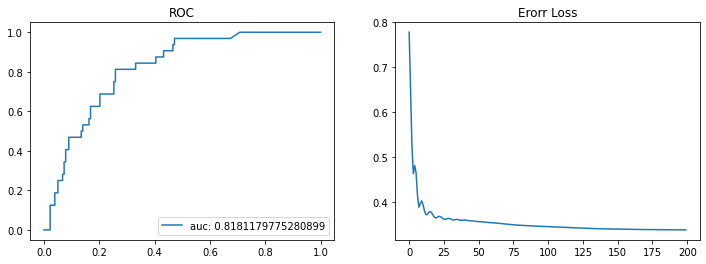

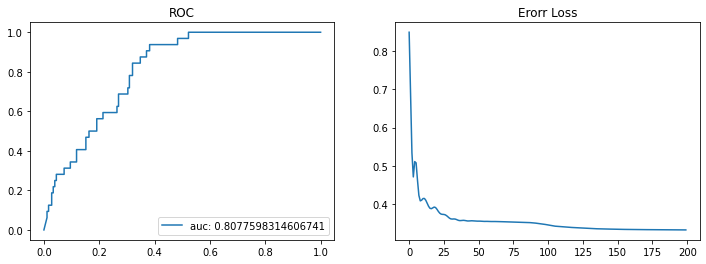

max AUC score of 10 k-Fold 0.8332482124616956


In [ ]:
ROC_curve(df_kc1, 8, 4, 0.15, 200,"kc1_BCE",pso2)

In [ ]:
pso2__hinge = get(p,lb,ub,it,c1,c2,w,node1,node2,lr,epochs,df_kc1,loss_function=2)

iterations 0 | min loss achieved inf using 0.0 features
iterations 5 | min loss achieved 1.0740239223651544 using 6 features
iterations 10 | min loss achieved 1.0740239223651544 using 6 features
iterations 15 | min loss achieved 1.0740239223651544 using 6 features
iterations 20 | min loss achieved 1.0740239223651544 using 6 features
iterations 25 | min loss achieved 1.0740239223651544 using 6 features
iterations 30 | min loss achieved 1.0740239223651544 using 6 features
iterations 35 | min loss achieved 1.0740239223651544 using 6 features
iterations 40 | min loss achieved 1.0740239223651544 using 6 features
iterations 45 | min loss achieved 1.0740239223651544 using 6 features
iterations 50 | min loss achieved 1.0740239223651544 using 6 features
iterations 55 | min loss achieved 1.0740239223651544 using 6 features
iterations 60 | min loss achieved 1.0740239223651544 using 6 features
iterations 65 | min loss achieved 1.0740239223651544 using 6 features
iterations 70 | min loss achieved 1

for kc1_Hinge
selected metrics :
number of features selected 6
['LOC_CODE_AND_COMMENT', 'ESSENTIAL_COMPLEXITY', 'HALSTEAD_DIFFICULTY', 'HALSTEAD_PROG_TIME', 'NUM_UNIQUE_OPERANDS', 'LOC_TOTAL']


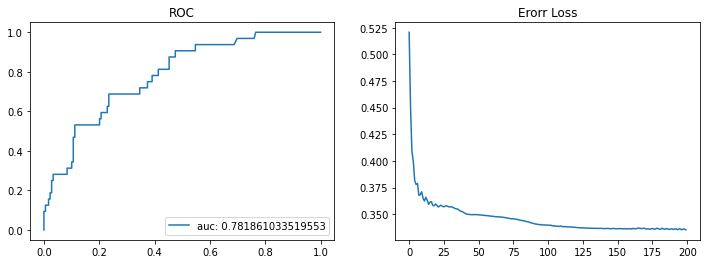

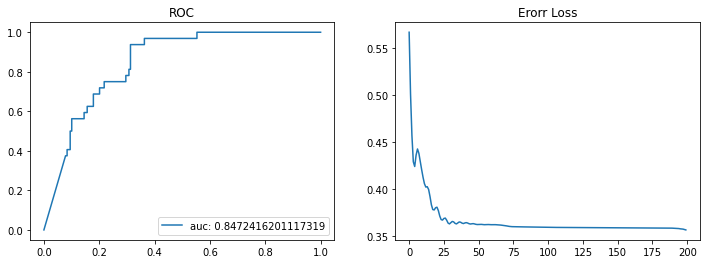

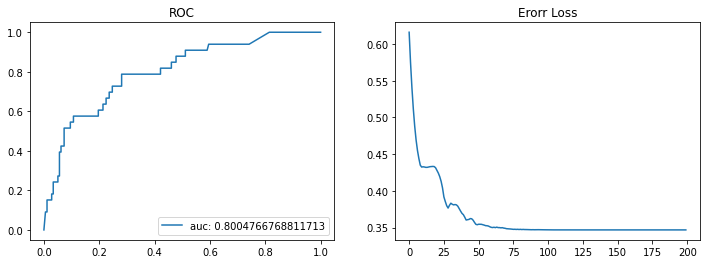

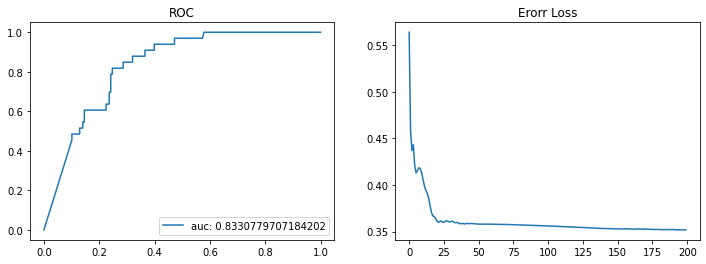

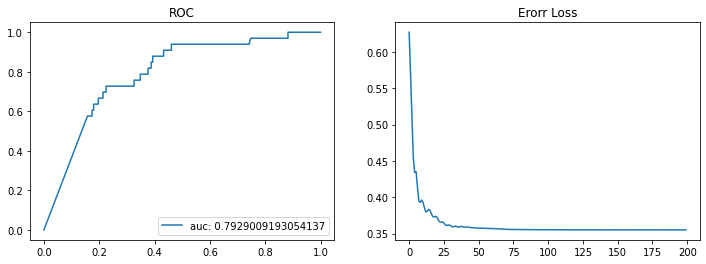

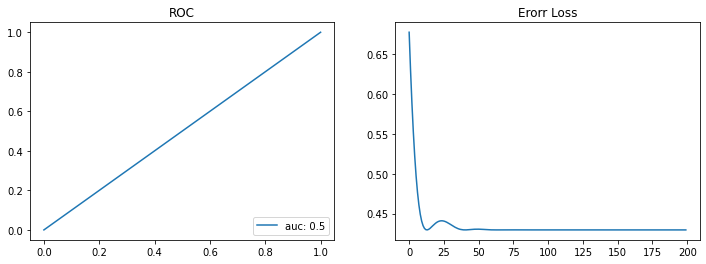

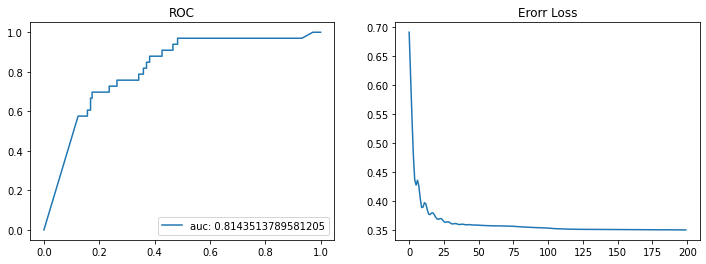

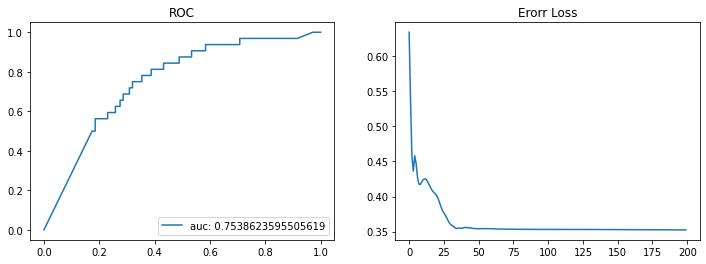

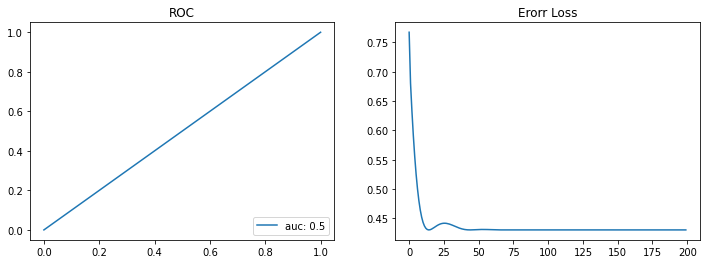

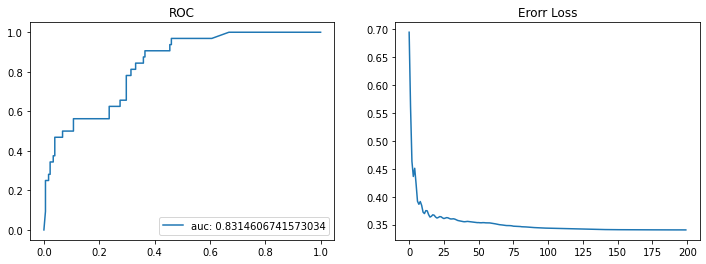

max AUC score of 10 k-Fold 0.8472416201117319


In [ ]:
ROC_curve(df_kc1, 8, 4, 0.15, 200,"kc1_Hinge",pso2__hinge)

In [ ]:
pso2__kl = get(p,lb,ub,it,c1,c2,w,node1,node2,lr,epochs,df_kc1,loss_function=3)

iterations 0 | min loss achieved inf using 0.0 features
iterations 5 | min loss achieved 219.83208709245838 using 9 features
iterations 10 | min loss achieved 219.83208709245838 using 9 features
iterations 15 | min loss achieved 219.83208709245838 using 9 features
iterations 20 | min loss achieved 219.83208709245838 using 9 features
iterations 25 | min loss achieved 214.83680184022774 using 9 features
iterations 30 | min loss achieved 214.83680184022774 using 9 features
iterations 35 | min loss achieved 214.83680184022774 using 9 features
iterations 40 | min loss achieved 214.83680184022774 using 9 features
iterations 45 | min loss achieved 214.83680184022774 using 9 features
iterations 50 | min loss achieved 214.83680184022774 using 9 features
iterations 55 | min loss achieved 184.5391642575493 using 3 features
iterations 60 | min loss achieved 184.5391642575493 using 3 features
iterations 65 | min loss achieved 184.5391642575493 using 3 features
iterations 70 | min loss achieved 184.

for kc1_KL
selected metrics :
number of features selected 3
['LOC_CODE_AND_COMMENT', 'HALSTEAD_EFFORT', 'NUM_UNIQUE_OPERATORS']


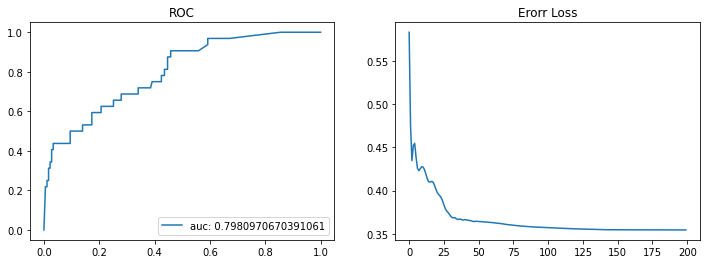

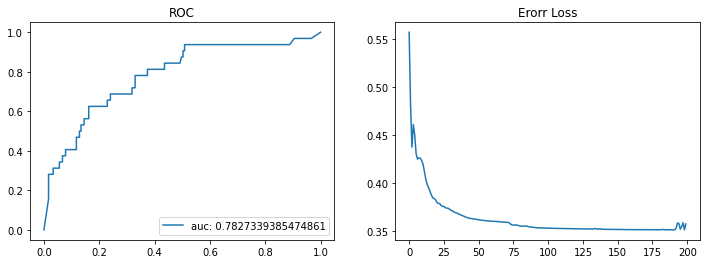

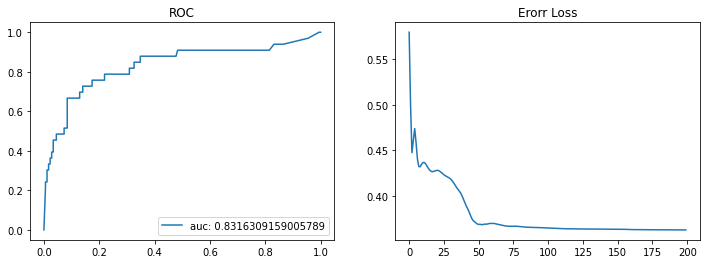

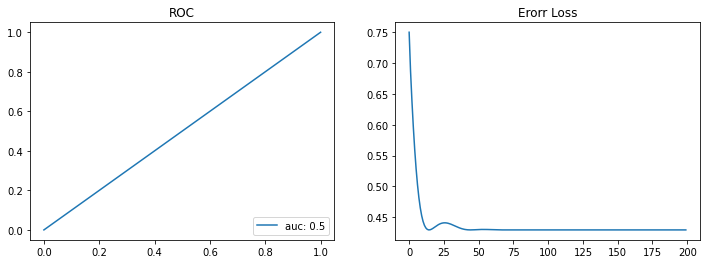

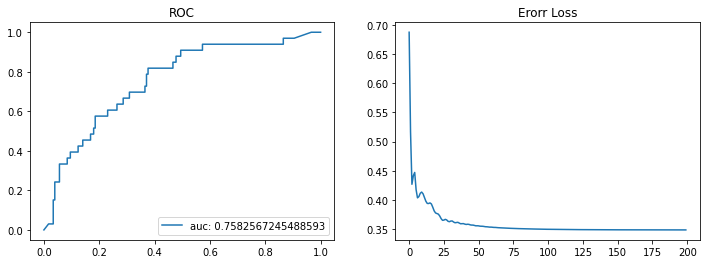

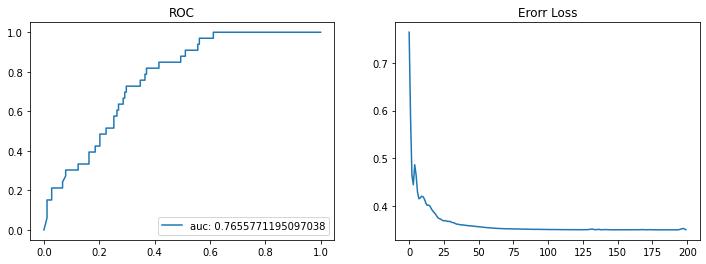

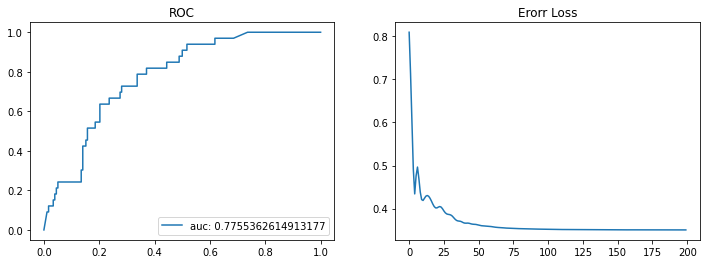

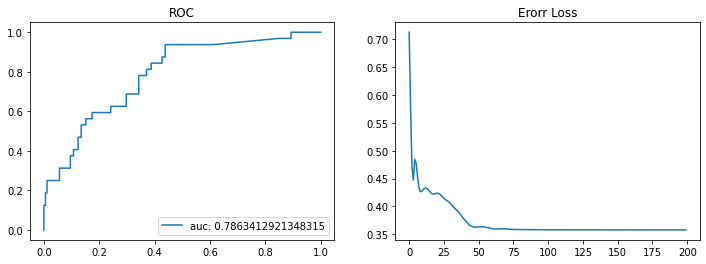

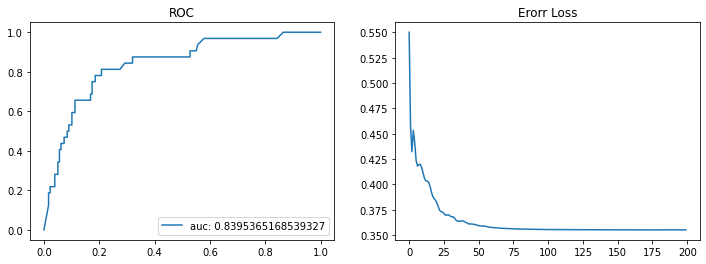

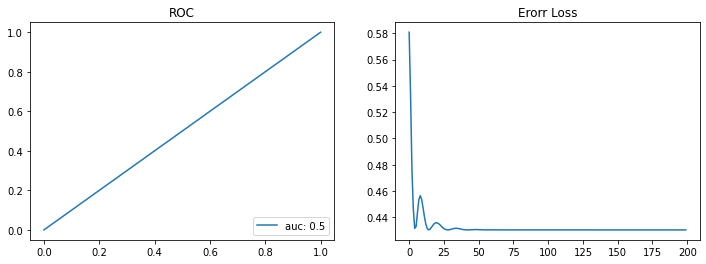

max AUC score of 10 k-Fold 0.8395365168539327


In [ ]:
ROC_curve(df_kc1, 8, 4, 0.15, 200,"kc1_KL",pso2__kl)

In [ ]:
pso3 = get(p,lb,ub,it,c1,c2,w,node1,node2,lr,epochs,df_kc3,loss_function=1)

iterations 0 | min loss achieved inf using 0.0 features
iterations 5 | min loss achieved 3.5099543109985056 using 10 features
iterations 10 | min loss achieved 2.9745159996507895 using 10 features
iterations 15 | min loss achieved 2.9745159996507895 using 10 features
iterations 20 | min loss achieved 2.9745159996507895 using 10 features
iterations 25 | min loss achieved 2.9745159996507895 using 10 features
iterations 30 | min loss achieved 2.9745159996507895 using 10 features
iterations 35 | min loss achieved 2.9745159996507895 using 10 features
iterations 40 | min loss achieved 2.9745159996507895 using 10 features
iterations 45 | min loss achieved 2.9745159996507895 using 10 features
iterations 50 | min loss achieved 2.9745159996507895 using 10 features
iterations 55 | min loss achieved 2.9745159996507895 using 10 features
iterations 60 | min loss achieved 2.9745159996507895 using 10 features
iterations 65 | min loss achieved 2.9745159996507895 using 10 features
iterations 70 | min lo

for kc3_BCE
selected metrics :
number of features selected 10
['BRANCH_COUNT', 'CYCLOMATIC_COMPLEXITY', 'LOC_EXECUTABLE', 'HALSTEAD_CONTENT', 'HALSTEAD_ERROR_EST', 'HALSTEAD_LENGTH', 'HALSTEAD_VOLUME', 'NUM_OPERANDS', 'NUM_UNIQUE_OPERANDS', 'LOC_TOTAL']


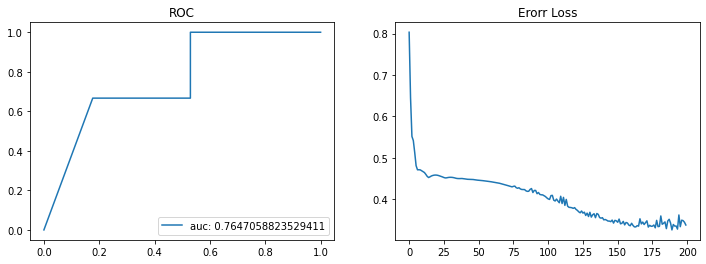

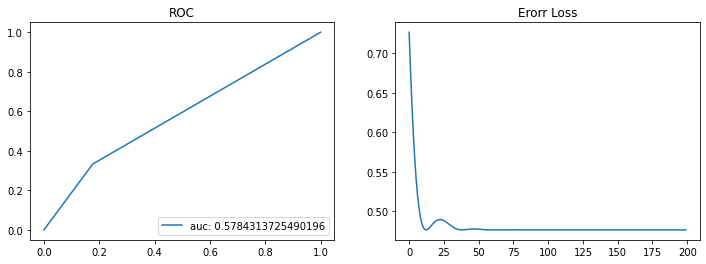

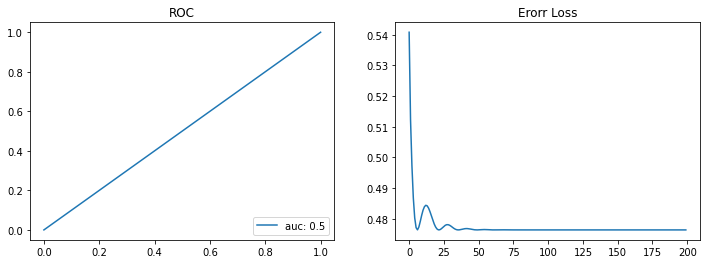

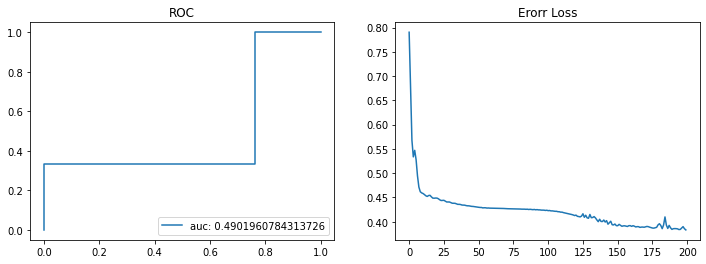

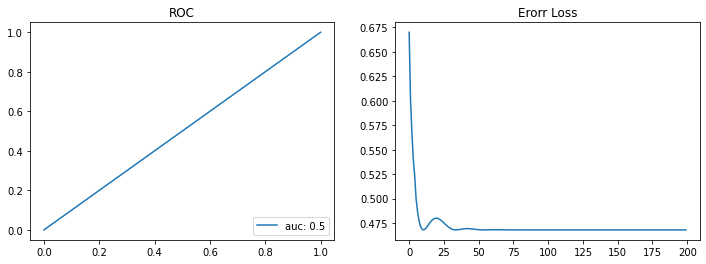

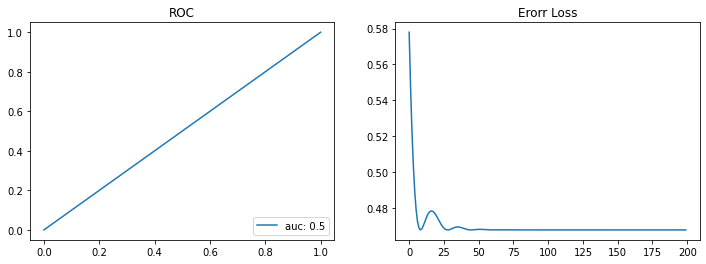

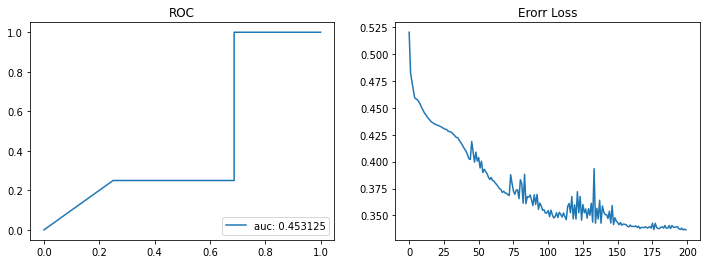

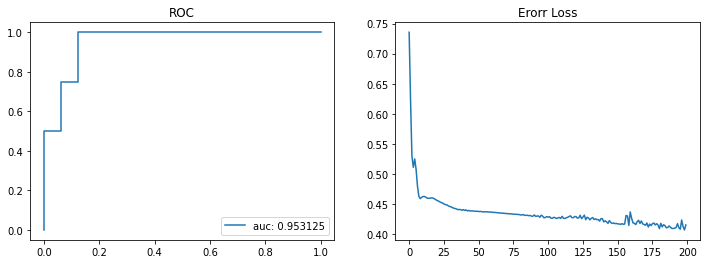

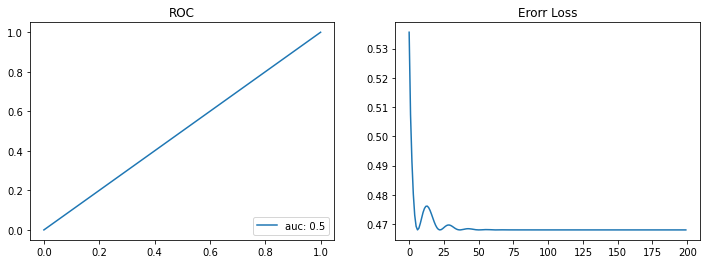

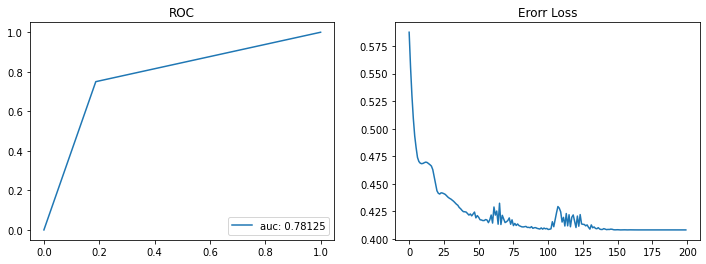

max AUC score of 10 k-Fold 0.953125


In [ ]:
ROC_curve(df_kc3, 8, 2, 0.15, 200,"kc3_BCE",pso3)

In [ ]:
pso3__hinge = get(p,lb,ub,it,c1,c2,w,node1,node2,lr,epochs,df_kc3,loss_function=2)

iterations 0 | min loss achieved inf using 0.0 features
iterations 5 | min loss achieved 1.0174999999999998 using 10 features
iterations 10 | min loss achieved 0.9974999999999999 using 10 features
iterations 15 | min loss achieved 0.9974999999999999 using 10 features
iterations 20 | min loss achieved 0.9874999999999998 using 8 features
iterations 25 | min loss achieved 0.9874999999999998 using 8 features
iterations 30 | min loss achieved 0.9874999999999998 using 8 features
iterations 35 | min loss achieved 0.9874999999999998 using 8 features
iterations 40 | min loss achieved 0.9874999999999998 using 8 features
iterations 45 | min loss achieved 0.9874999999999998 using 8 features
iterations 50 | min loss achieved 0.9874999999999998 using 8 features
iterations 55 | min loss achieved 0.9874999999999998 using 8 features
iterations 60 | min loss achieved 0.9874999999999998 using 8 features
iterations 65 | min loss achieved 0.9874999999999998 using 8 features
iterations 70 | min loss achieve

for kc3_Hinge
selected metrics :
number of features selected 10
['LOC_BLANK', 'CYCLOMATIC_COMPLEXITY', 'HALSTEAD_DIFFICULTY', 'HALSTEAD_EFFORT', 'HALSTEAD_ERROR_EST', 'HALSTEAD_LENGTH', 'NUM_OPERANDS', 'NUM_OPERATORS', 'NUM_UNIQUE_OPERANDS', 'NUM_UNIQUE_OPERATORS']


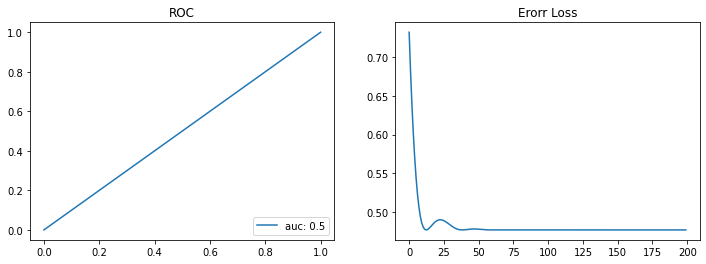

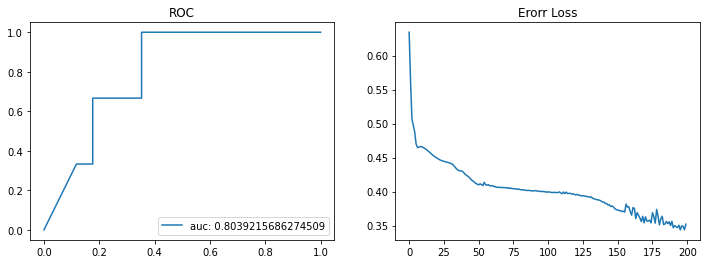

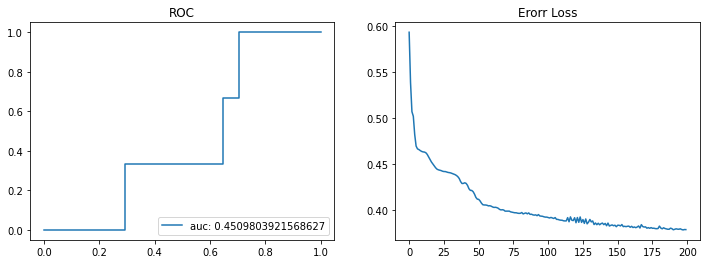

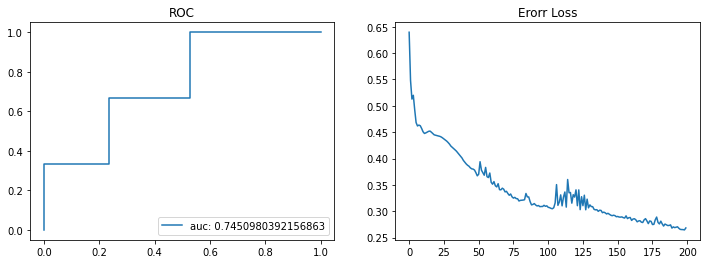

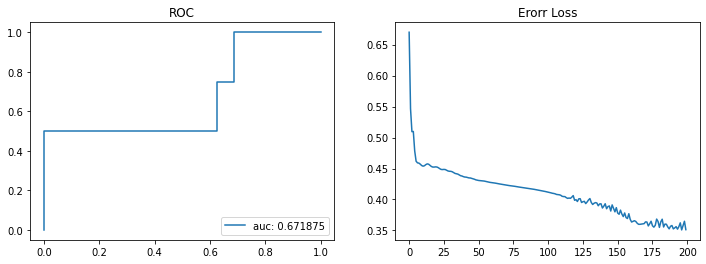

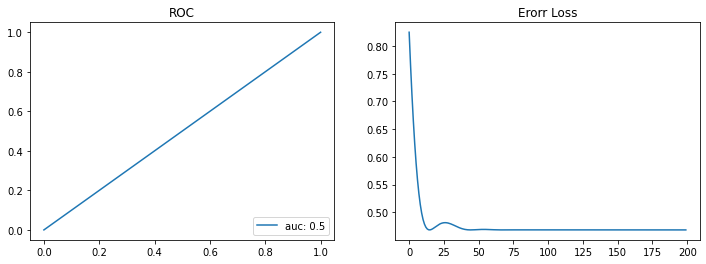

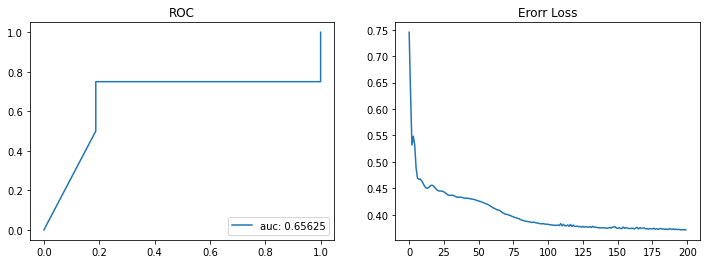

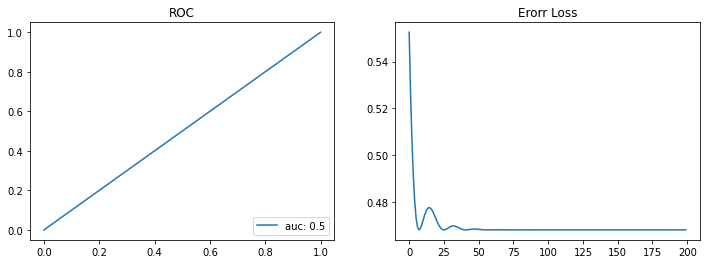

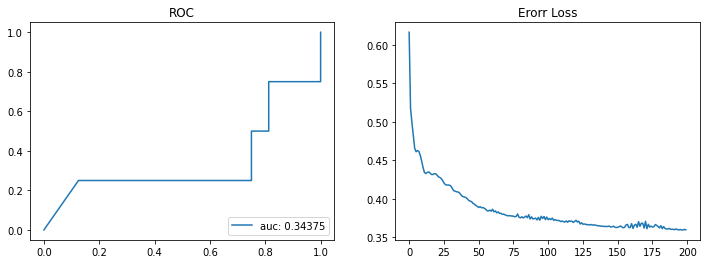

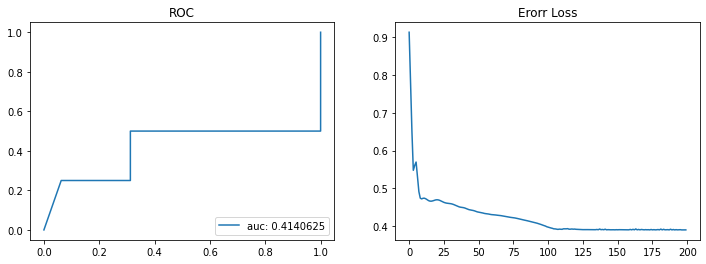

max AUC score of 10 k-Fold 0.8039215686274509


In [ ]:
ROC_curve(df_kc3, 8, 2, 0.15, 200,"kc3_Hinge",pso3__hinge)

In [ ]:
pso3__kl = get(p,lb,ub,it,c1,c2,w,node1,node2,lr,epochs,df_kc3,loss_function=3)

iterations 0 | min loss achieved inf using 0.0 features
iterations 5 | min loss achieved 16.28357975962057 using 10 features
iterations 10 | min loss achieved 16.21401510677749 using 10 features
iterations 15 | min loss achieved 16.21401510677749 using 10 features
iterations 20 | min loss achieved 16.21401510677749 using 10 features
iterations 25 | min loss achieved 14.258072342736408 using 10 features
iterations 30 | min loss achieved 12.093873264057738 using 10 features
iterations 35 | min loss achieved 12.093873264057738 using 10 features
iterations 40 | min loss achieved 12.093873264057738 using 10 features
iterations 45 | min loss achieved 12.093873264057738 using 10 features
iterations 50 | min loss achieved 12.093873264057738 using 10 features
iterations 55 | min loss achieved 12.093873264057738 using 10 features
iterations 60 | min loss achieved 12.093873264057738 using 10 features
iterations 65 | min loss achieved 12.093873264057738 using 10 features
iterations 70 | min loss a

for kc3_KL
selected metrics :
number of features selected 10
['BRANCH_COUNT', 'LOC_CODE_AND_COMMENT', 'LOC_EXECUTABLE', 'HALSTEAD_CONTENT', 'HALSTEAD_DIFFICULTY', 'HALSTEAD_LENGTH', 'HALSTEAD_LEVEL', 'HALSTEAD_PROG_TIME', 'HALSTEAD_VOLUME', 'LOC_TOTAL']


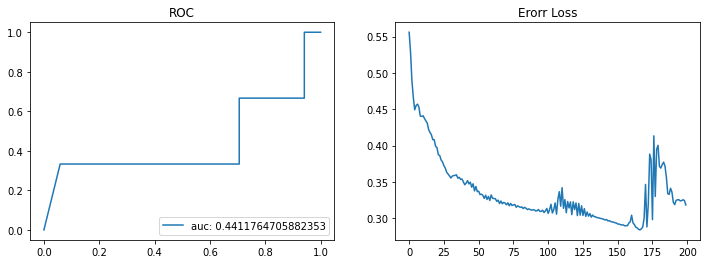

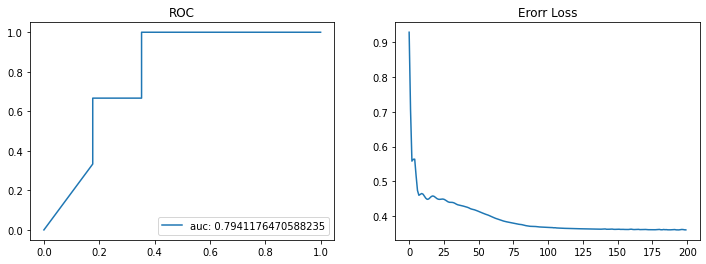

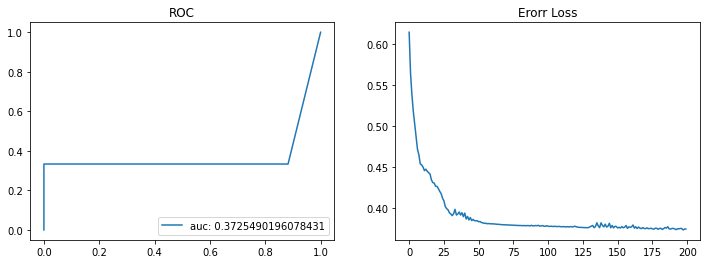

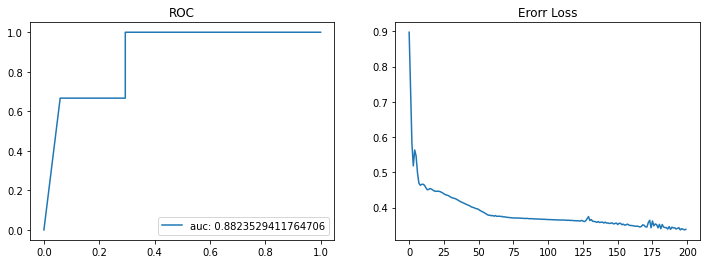

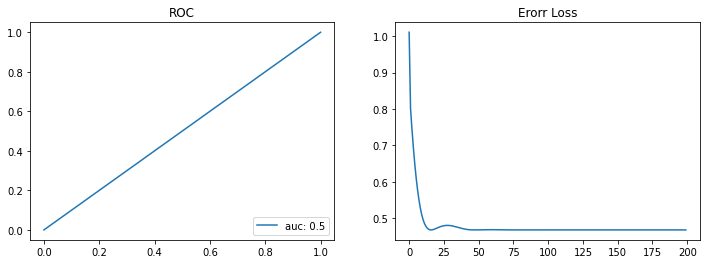

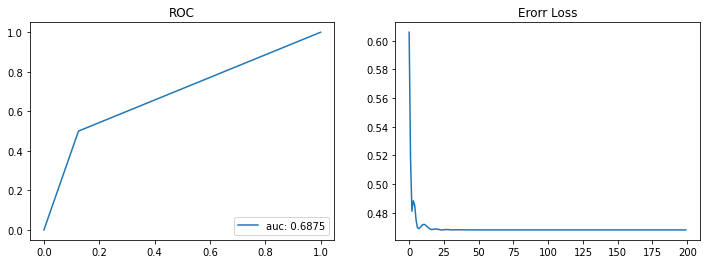

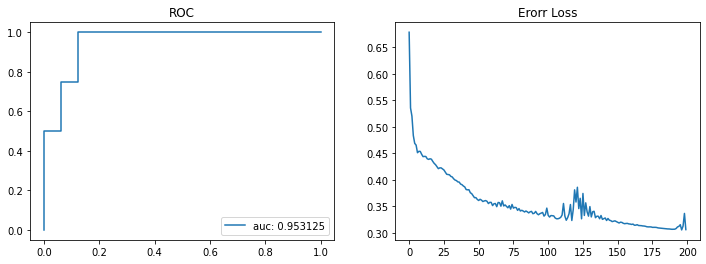

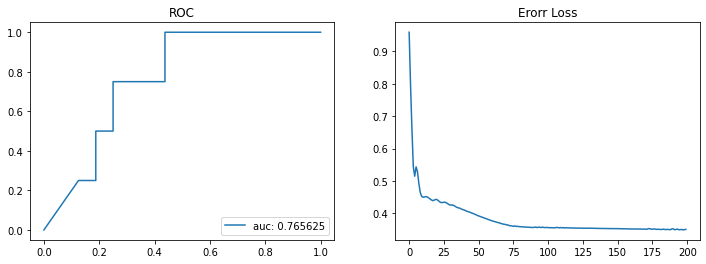

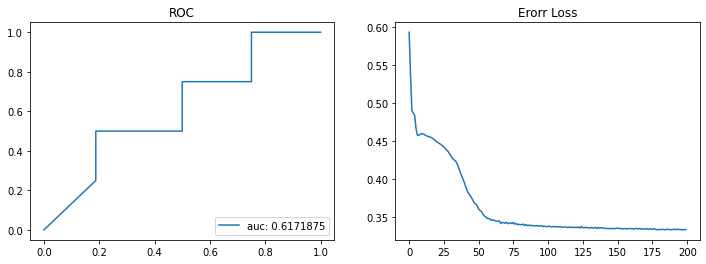

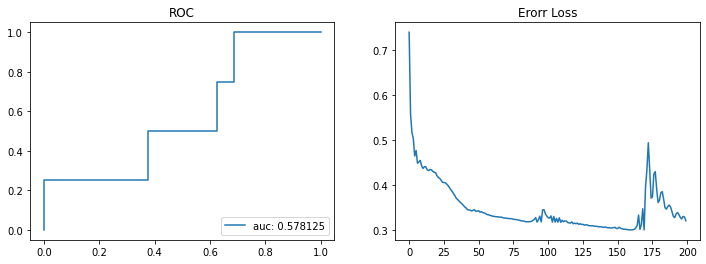

max AUC score of 10 k-Fold 0.953125


In [ ]:
ROC_curve(df_kc3, 8, 2, 0.15, 200,"kc3_KL",pso3__kl)

In [ ]:
pso4 = get(p,lb,ub,it,c1,c2,w,node1,node2,lr,epochs,df_jm1,loss_function=1)

iterations 0 | min loss achieved inf using 0.0 features
iterations 5 | min loss achieved 3.3607045195001013 using 6 features
iterations 10 | min loss achieved 2.931011692146024 using 5 features
iterations 15 | min loss achieved 2.931011692146024 using 5 features
iterations 20 | min loss achieved 2.930114084696342 using 5 features
iterations 25 | min loss achieved 2.8138763904523976 using 6 features
iterations 30 | min loss achieved 2.8138763904523976 using 6 features
iterations 35 | min loss achieved 2.8138763904523976 using 6 features
iterations 40 | min loss achieved 2.8138763904523976 using 6 features
iterations 45 | min loss achieved 2.8110675994499124 using 6 features
iterations 50 | min loss achieved 2.8110675994499124 using 6 features
iterations 55 | min loss achieved 2.8110675994499124 using 6 features
iterations 60 | min loss achieved 2.8110675994499124 using 6 features
iterations 65 | min loss achieved 2.8110675994499124 using 6 features
iterations 70 | min loss achieved 2.81

for jm1_BCE
selected metrics :
number of features selected 6
['LOC_CODE_AND_COMMENT', 'CYCLOMATIC_COMPLEXITY', 'HALSTEAD_LENGTH', 'HALSTEAD_LEVEL', 'NUM_OPERANDS', 'NUM_OPERATORS']


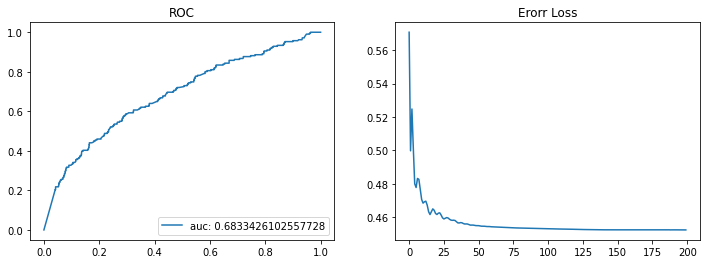

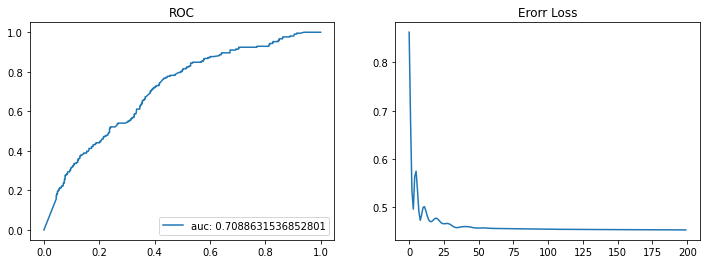

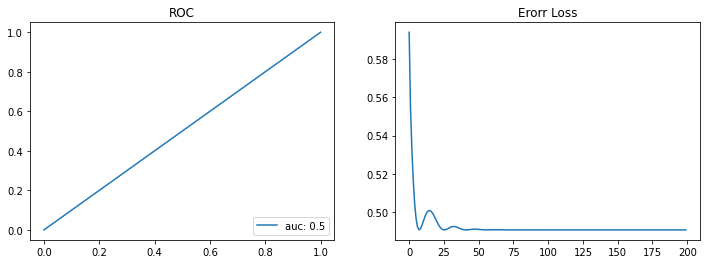

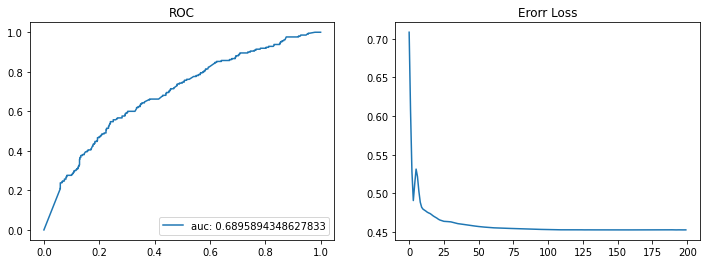

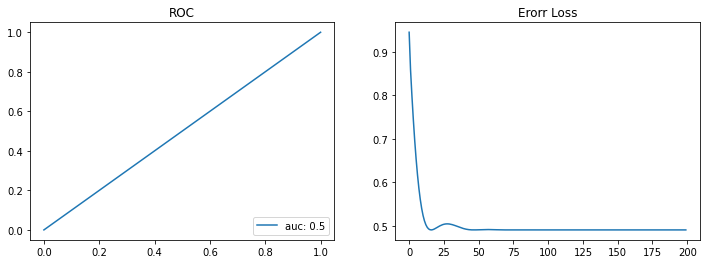

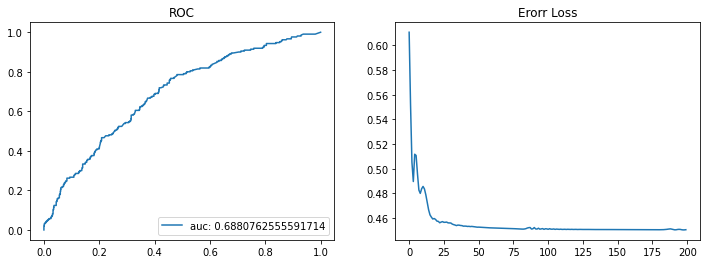

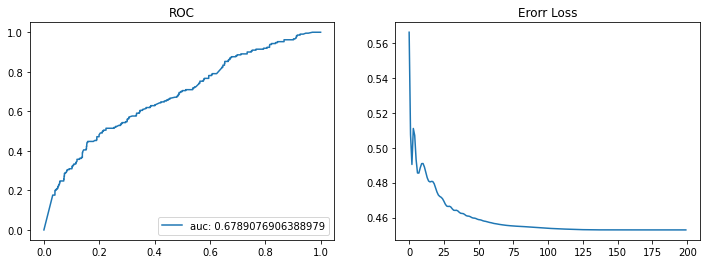

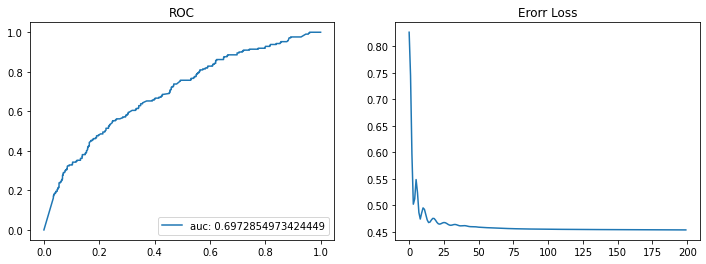

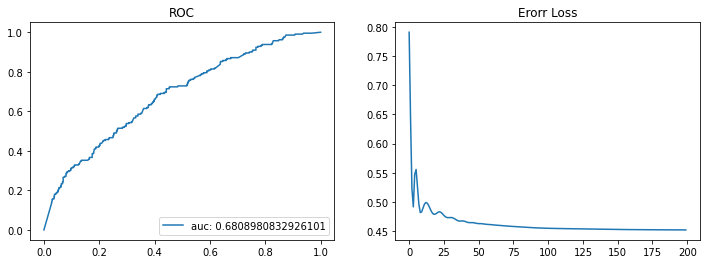

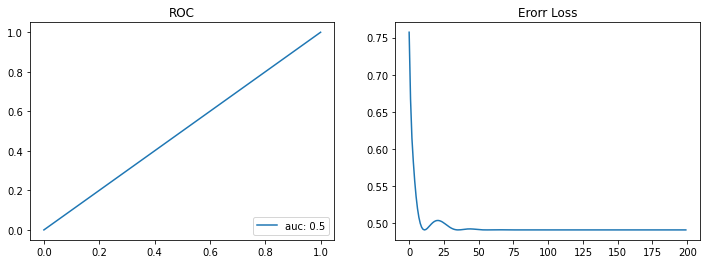

max AUC score of 10 k-Fold 0.7088631536852801


In [ ]:
ROC_curve(df_jm1, 8, 2, 0.15, 200,"jm1_BCE",pso4)

In [ ]:
pso4__hinge = get(p,lb,ub,it,c1,c2,w,node1,node2,lr,epochs,df_jm1,loss_function=2)

iterations 0 | min loss achieved inf using 0.0 features
iterations 5 | min loss achieved 0.9539453568916066 using 5 features
iterations 10 | min loss achieved 0.9539453568916066 using 5 features
iterations 15 | min loss achieved 0.9538220327804534 using 6 features
iterations 20 | min loss achieved 0.9538220327804534 using 6 features
iterations 25 | min loss achieved 0.9538220327804534 using 6 features
iterations 30 | min loss achieved 0.9538220327804534 using 6 features
iterations 35 | min loss achieved 0.9538220327804534 using 6 features
iterations 40 | min loss achieved 0.9538220327804534 using 6 features
iterations 45 | min loss achieved 0.9538220327804534 using 6 features
iterations 50 | min loss achieved 0.9538220327804534 using 6 features
iterations 55 | min loss achieved 0.9538220327804534 using 6 features
iterations 60 | min loss achieved 0.9538220327804534 using 6 features
iterations 65 | min loss achieved 0.9538220327804534 using 6 features
iterations 70 | min loss achieved 0

for jm1_Hinge
selected metrics :
number of features selected 5
['LOC_CODE_AND_COMMENT', 'HALSTEAD_DIFFICULTY', 'NUM_OPERATORS', 'NUM_UNIQUE_OPERANDS', 'NUM_UNIQUE_OPERATORS']


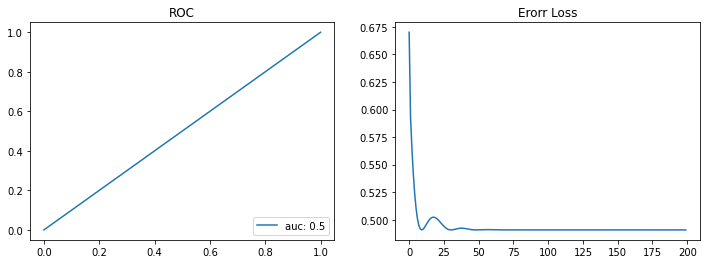

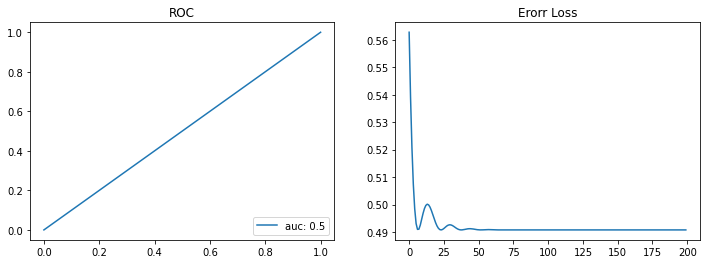

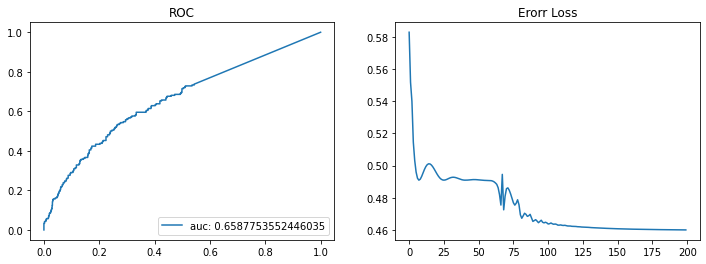

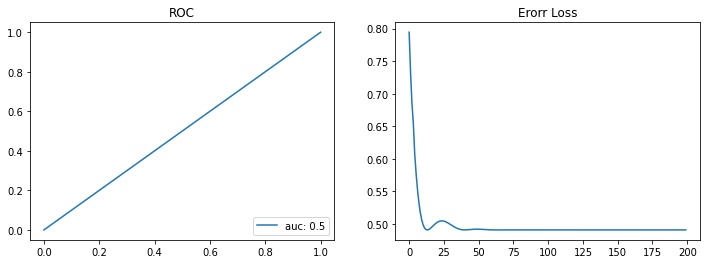

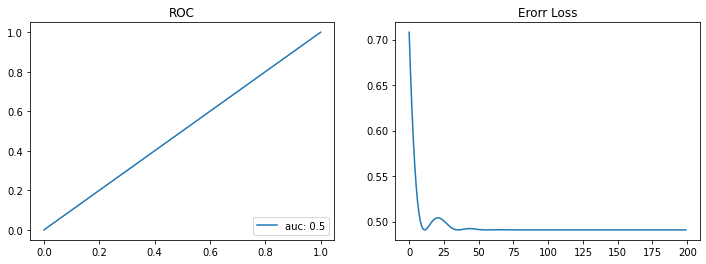

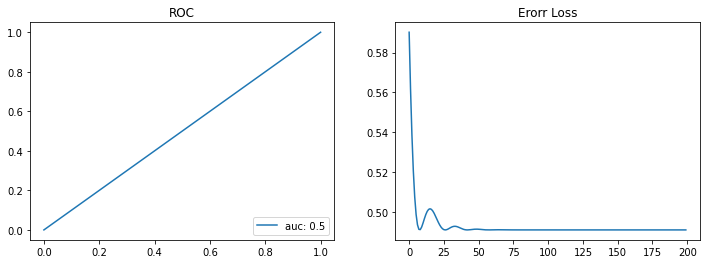

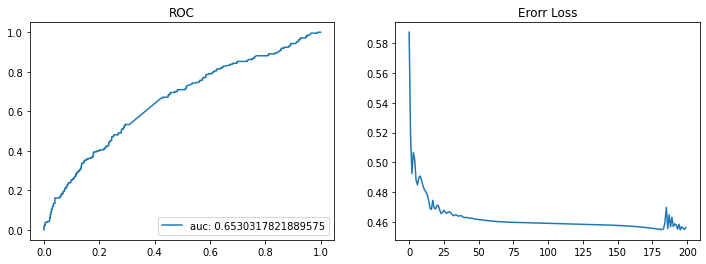

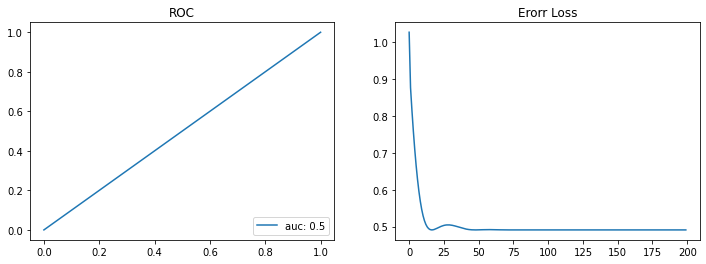

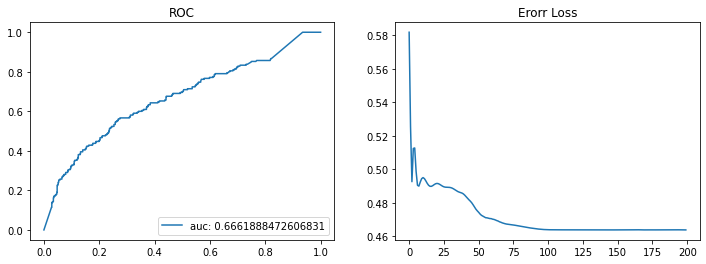

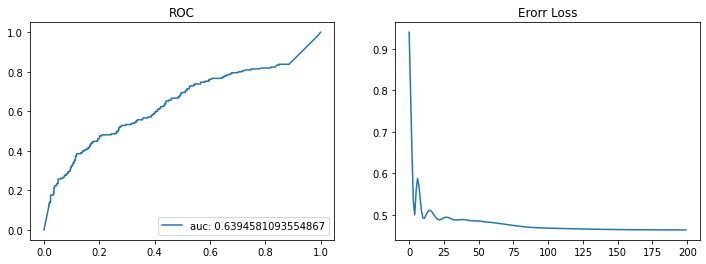

max AUC score of 10 k-Fold 0.6661888472606831


In [ ]:
ROC_curve(df_jm1, 8, 2, 0.15, 200,"jm1_Hinge",pso4__hinge)

In [ ]:
pso4__kl = get(p,lb,ub,it,c1,c2,w,node1,node2,lr,epochs,df_jm1,loss_function=3)

iterations 0 | min loss achieved inf using 0.0 features
iterations 5 | min loss achieved 528.958332266108 using 5 features
iterations 10 | min loss achieved 528.958332266108 using 5 features
iterations 15 | min loss achieved 528.958332266108 using 5 features
iterations 20 | min loss achieved 528.958332266108 using 5 features
iterations 25 | min loss achieved 528.958332266108 using 5 features
iterations 30 | min loss achieved 528.958332266108 using 5 features
iterations 35 | min loss achieved 453.64451757518856 using 3 features
iterations 40 | min loss achieved 453.64451757518856 using 3 features
iterations 45 | min loss achieved 453.64451757518856 using 3 features
iterations 50 | min loss achieved 453.64451757518856 using 3 features
iterations 55 | min loss achieved 453.64451757518856 using 3 features
iterations 60 | min loss achieved 453.64451757518856 using 3 features
iterations 65 | min loss achieved 453.64451757518856 using 3 features
iterations 70 | min loss achieved 453.644517575

for jm1_KL
selected metrics :
number of features selected 3
['LOC_CODE_AND_COMMENT', 'CYCLOMATIC_COMPLEXITY', 'HALSTEAD_LENGTH']


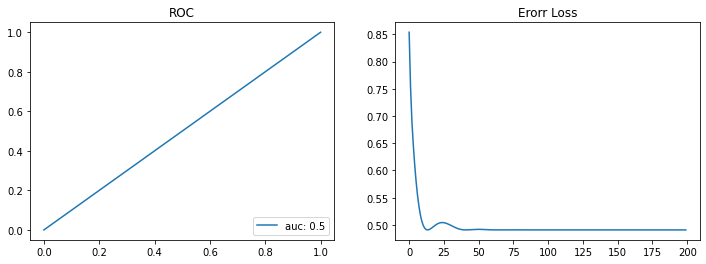

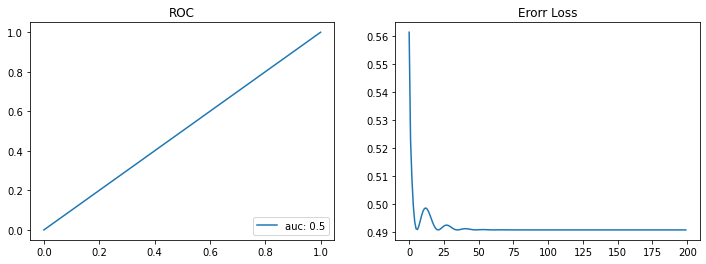

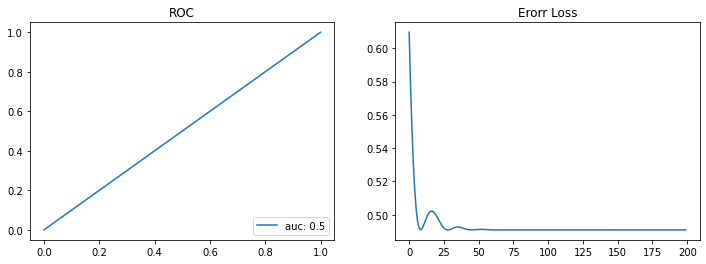

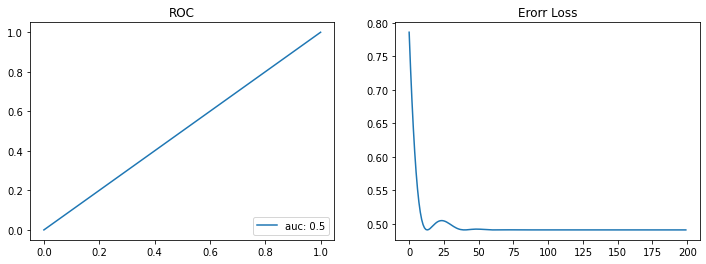

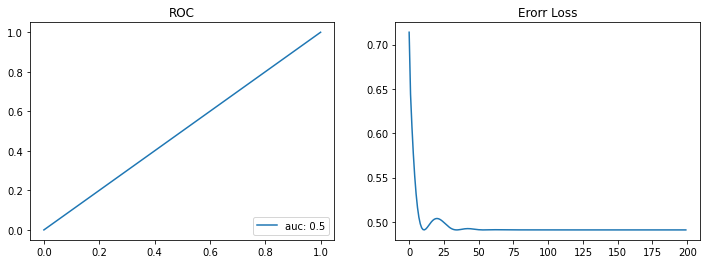

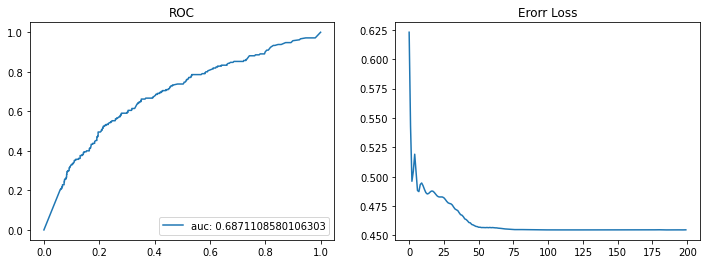

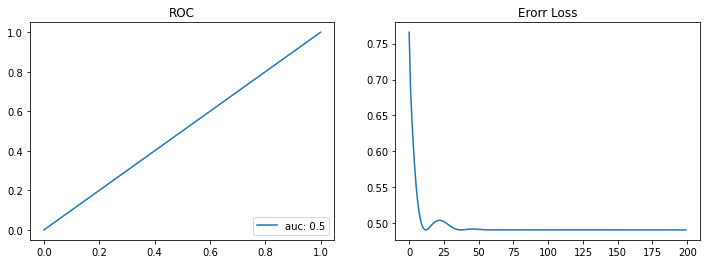

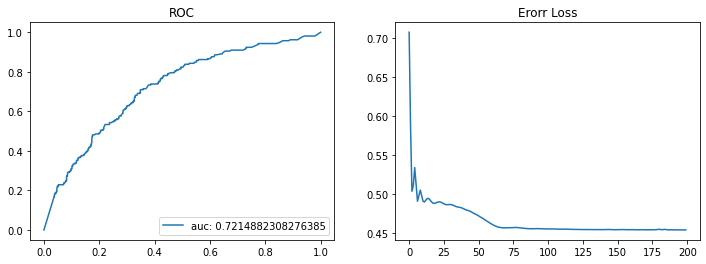

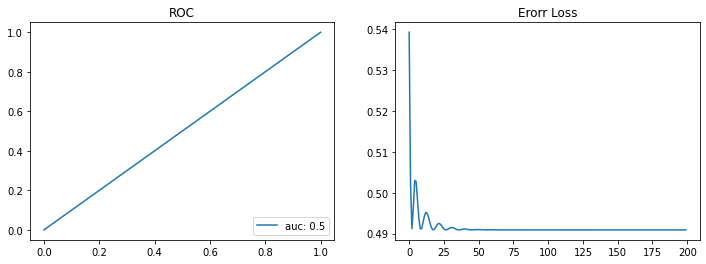

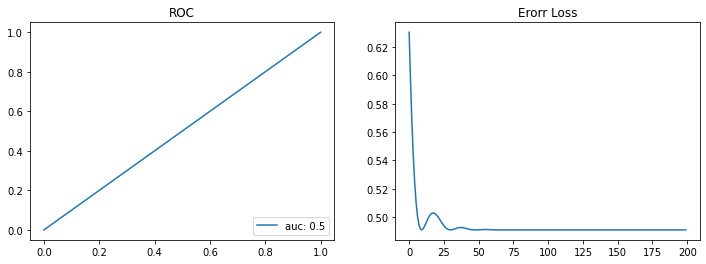

max AUC score of 10 k-Fold 0.7214882308276385


In [ ]:
ROC_curve(df_jm1, 8, 2, 0.15, 200,"jm1_KL",pso4__kl)